In [1]:
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import iqr
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits
from astropy import constants
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support

import missingno as missno
from tqdm import tqdm

In [2]:
#Move up to RAFTS directory
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('../../')

In [ ]:

from config import *

from utils import filt_interp, dpar, dtan, lamb_eff_md, dcr_offset, celest_to_pa, inverse_Teff, inverseTeff, inverseWeff, lorentzian, chrDistAng
import globals

In [4]:
SAVE = True
D2ARCSEC = 3_600
DAY2SEC = 24 * 3_600


In [5]:
!pwd

/Users/fbianco/RAFTS


In [6]:
main_df = pd.read_csv("Outdata/main_df_GaussPSF.csv")
main_df

,id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fwhm_init,y_fwhm_init,x_fit,...,y_fwhm_err,npixfit,qfit,cfit,flags,RA,DEC,RA_ERR,DEC_ERR,time
0,1.0,1.0,1.0,32.860002,868.522296,21.285904,126752.984875,1.0,1.0,868.901854,...,0.019373,625.0,0.139842,0.001461,0.0,45.554966,-54.992271,0.000001,5.377676e-07,57374.240660
1,67.0,67.0,1.0,22.824020,184.676236,2398.123898,9088.540348,1.0,1.0,184.788578,...,0.069575,625.0,0.798354,0.000974,0.0,45.856575,-54.940755,0.000004,1.952583e-06,57374.240660
2,66.0,66.0,1.0,22.704307,1300.432535,2334.177144,8039.251865,1.0,1.0,1300.538688,...,0.136910,625.0,1.404182,0.001640,0.0,45.850447,-55.022310,0.000007,4.226357e-06,57374.240660
3,65.0,65.0,1.0,23.986071,1134.901937,2308.007500,11107.253667,1.0,1.0,1134.845481,...,0.042059,625.0,0.446303,0.001646,0.0,45.846829,-55.010223,0.000002,1.151464e-06,57374.240660
4,64.0,64.0,1.0,23.267743,89.050946,2290.185485,9862.451182,1.0,1.0,88.927061,...,0.057909,625.0,0.618064,0.001374,0.0,45.842770,-54.933839,0.000003,1.546420e-06,57374.240660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,25.0,25.0,1.0,30.836489,1711.013637,1002.334108,10776.370524,1.0,1.0,1713.230690,...,0.240641,625.0,2.280585,0.001066,0.0,45.681360,-55.053572,0.000013,6.532347e-06,57374.281315
6656,24.0,24.0,1.0,27.664921,1353.061647,945.537470,10435.065140,1.0,1.0,1356.854621,...,0.095976,625.0,0.870087,-0.002466,0.0,45.673733,-55.027555,0.000005,2.499945e-06,57374.281315
6657,22.0,22.0,1.0,27.925559,1215.973622,926.975891,9584.155881,1.0,1.0,1216.566541,...,0.140216,625.0,1.549302,-0.004060,0.0,45.671096,-55.017312,0.000008,3.804777e-06,57374.281315
6658,31.0,31.0,1.0,55.709088,1824.498209,1213.554383,57115.466188,1.0,1.0,1824.834737,...,0.092717,625.0,0.615803,0.000643,0.0,45.708521,-55.061596,0.000005,2.426805e-06,57374.281315


In [7]:
flr_id = 11
FLAREINDX = flr_id - 1

In [8]:
main_df.shape, main_df.columns

((6660, 28),
 Index(['id', 'group_id', 'group_size', 'local_bkg', 'x_init', 'y_init',
        'flux_init', 'x_fwhm_init', 'y_fwhm_init', 'x_fit', 'y_fit', 'flux_fit',
        'x_fwhm_fit', 'y_fwhm_fit', 'x_err', 'y_err', 'flux_err', 'x_fwhm_err',
        'y_fwhm_err', 'npixfit', 'qfit', 'cfit', 'flags', 'RA', 'DEC', 'RA_ERR',
        'DEC_ERR', 'time'],
       dtype='object'))

<Axes: >

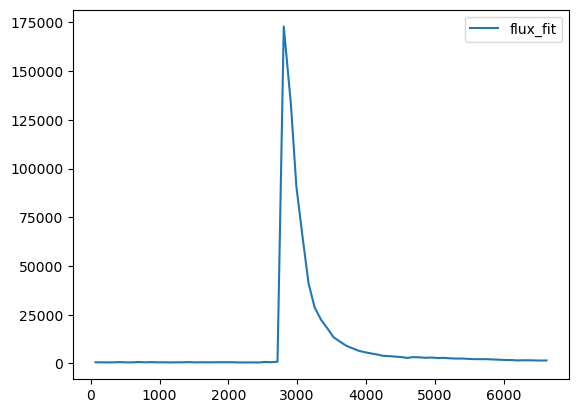

In [9]:
main_df[main_df['id'] == flr_id].plot(y="flux_fit")

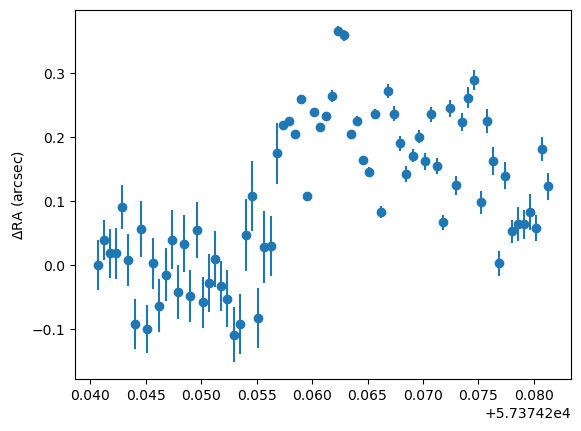

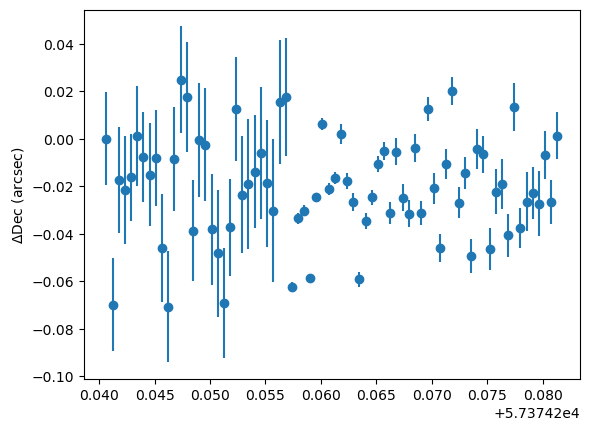

In [10]:

plt.errorbar(main_df['time'][main_df['id'] == flr_id], 
             (main_df['RA'][main_df['id'] == flr_id] - main_df['RA'][main_df['id'] == flr_id].iloc[0]) * 3600, 
             yerr = main_df['RA_ERR'][main_df['id'] == flr_id] * 3600, marker='o', ls='None')
plt.ylabel(r'$\Delta$RA (arcsec)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], 
             (main_df['DEC'][main_df['id'] == flr_id] - main_df['DEC'][main_df['id'] == flr_id].iloc[0]) * 3600, 
             yerr = main_df['DEC_ERR'][main_df['id'] == flr_id] * 3600, marker='o', ls='None')
plt.ylabel(r'$\Delta$Dec (arcsec)')
plt.show()

In [11]:
main_df.columns

Index(['id', 'group_id', 'group_size', 'local_bkg', 'x_init', 'y_init',
       'flux_init', 'x_fwhm_init', 'y_fwhm_init', 'x_fit', 'y_fit', 'flux_fit',
       'x_fwhm_fit', 'y_fwhm_fit', 'x_err', 'y_err', 'flux_err', 'x_fwhm_err',
       'y_fwhm_err', 'npixfit', 'qfit', 'cfit', 'flags', 'RA', 'DEC', 'RA_ERR',
       'DEC_ERR', 'time'],
      dtype='object')

In [12]:
display(main_df[main_df['id'] == flr_id])

,id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fwhm_init,y_fwhm_init,x_fit,...,y_fwhm_err,npixfit,qfit,cfit,flags,RA,DEC,RA_ERR,DEC_ERR,time
68,11.0,11.0,1.0,22.906959,321.028700,428.625597,7869.483224,1.0,1.0,320.580465,...,0.203067,625.0,2.282709,-0.000852,0.0,45.606318,-54.951988,0.000011,0.000005,57374.240660
147,11.0,11.0,1.0,23.324450,321.482097,428.299132,7888.145315,1.0,1.0,321.136916,...,0.161823,625.0,2.354183,-0.000825,0.0,45.606329,-54.952008,0.000009,0.000005,57374.241217
239,11.0,11.0,1.0,23.786113,321.025249,428.477491,7818.467249,1.0,1.0,320.648333,...,0.197335,625.0,2.575127,0.006711,0.0,45.606323,-54.951993,0.000011,0.000006,57374.241772
330,11.0,9.0,1.0,22.647572,320.723113,429.079165,7677.520572,1.0,1.0,320.351508,...,0.203305,625.0,2.252085,-0.000328,0.0,45.606323,-54.951994,0.000011,0.000006,57374.242328
420,11.0,11.0,1.0,21.880405,321.212230,428.123054,7713.222365,1.0,1.0,320.844773,...,0.180133,625.0,2.038953,0.006879,0.0,45.606343,-54.951993,0.000010,0.000005,57374.242878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6293,11.0,11.0,1.0,26.587003,320.568675,426.420864,9966.413581,1.0,1.0,320.206415,...,0.117238,625.0,0.897742,-0.002499,0.0,45.606336,-54.951995,0.000006,0.000003,57374.279094
6370,11.0,11.0,1.0,26.605653,320.754930,427.911461,9983.583038,1.0,1.0,320.335626,...,0.146859,625.0,0.888011,0.003106,0.0,45.606341,-54.951996,0.000008,0.000004,57374.279650
6460,11.0,10.0,1.0,26.597493,320.348323,426.722280,9965.722044,1.0,1.0,319.910512,...,0.107945,625.0,0.926320,0.003233,0.0,45.606334,-54.951990,0.000006,0.000003,57374.280204
6543,11.0,9.0,1.0,26.790252,319.828363,427.416710,9925.742132,1.0,1.0,319.657001,...,0.095835,625.0,0.975837,0.008874,0.0,45.606369,-54.951996,0.000005,0.000003,57374.280761


In [13]:
main_df['id'].unique().shape

(92,)

In [14]:
t_index = []
for i, time in enumerate(main_df['time'].dropna().unique()):

    if (main_df['time'][main_df['id'] == flr_id].values == time).any():
        t_index.append(True)

    else:
        t_index.append(False) 

In [15]:
NDPS = len(t_index)

(92,)

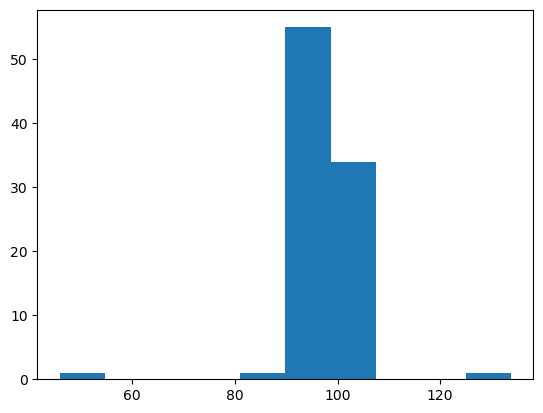

In [16]:
m = []

for id in main_df['id'].unique():
    m.append((main_df[main_df['id'] == id].shape[0] / NDPS) * 100)

m = np.array(m)
plt.hist(m)
m.shape

In [17]:
len(m[m == 100.0]) #what is thhis?

34

In [18]:
len(m[m > 80])  #what is thhis?

91

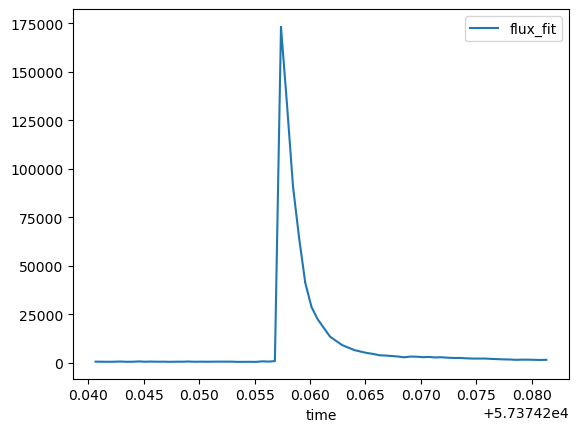

In [19]:
main_df[main_df['id'] == flr_id].plot(x = 'time', y='flux_fit', yerr='flux_err');

In [20]:
g_flux = main_df[main_df['id'] == flr_id]['flux_fit']
g_flux_err = main_df[main_df['id'] == flr_id]['flux_err']
flr_times = main_df[main_df['id'] == flr_id]['time']
g_mag = 22.5 - 2.5 * np.log10(g_flux.values)
g_mag_err = (2.5/np.log(10)) * (g_flux_err/g_flux)
g_mag_err = g_mag_err.values
#average initial pre-flare flux
delta_g_mag = g_mag - np.mean(g_mag[((flr_times - flr_times.iloc[0]) * DAY2SEC) < 1000])
delta_g_mag_err = g_mag_err #- np.sqrt(np.sum(g_mag_err[((flr_times - flr_times.iloc[0]) * DAY2SEC) < 1000] ** 2)) /  len(g_mag_err[((flr_times - flr_times.iloc[0]) * DAY2SEC) < 1000])

for i, t in enumerate(t_index):
    if not t:
        delta_g_mag = np.insert(delta_g_mag, i, np.nan)
        delta_g_mag_err = np.insert(delta_g_mag_err, i, np.nan)
    else:
        pass

g_flux.shape, delta_g_mag.shape, delta_g_mag_err

((74,),
 (74,),
 array([0.04642647, 0.04507546, 0.05073863, 0.04838615, 0.04216267,
        0.05037452, 0.04807693, 0.04537627, 0.04719053, 0.04632503,
        0.0503911 , 0.04872411, 0.05492569, 0.05049603, 0.05054858,
        0.04561413, 0.05148256, 0.04759618, 0.05253255, 0.0497327 ,
        0.04557643, 0.04835572, 0.0493424 , 0.05907676, 0.0570861 ,
        0.05890338, 0.05858066, 0.0506019 , 0.05040164, 0.04337259,
        0.00401605, 0.00424869, 0.00408875, 0.00344604, 0.00399963,
        0.00454191, 0.0048068 , 0.00472586, 0.00697389, 0.00583571,
        0.0069702 , 0.00626364, 0.00703428, 0.00697216, 0.00759105,
        0.00820947, 0.00992842, 0.01082952, 0.01156819, 0.01189827,
        0.01269535, 0.01090799, 0.01080417, 0.01315029, 0.01256556,
        0.01339929, 0.01230743, 0.01423044, 0.01569417, 0.01530106,
        0.01695721, 0.01646891, 0.01788918, 0.01729987, 0.01988657,
        0.01960675, 0.02137925, 0.01947633, 0.02517179, 0.02199648,
        0.02454227, 0.02165249, 

In [21]:
flr_id

11

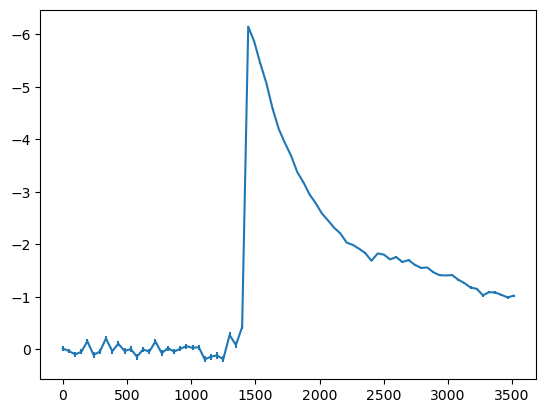

In [22]:
times = main_df['time'].dropna().unique() 
# you were doing this subtraction and the conversion to second 50 times and then you were creating this variable way below...
tSec = (times - times[0]) * DAY2SEC
plt.errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err)
plt.gca().invert_yaxis()

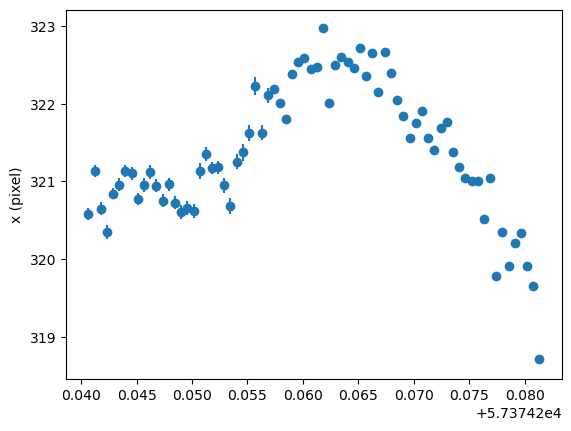

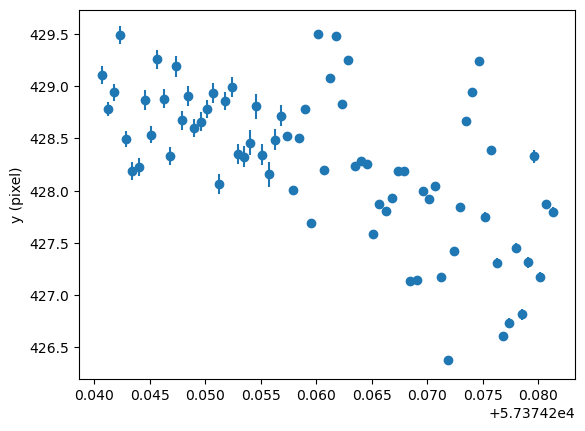

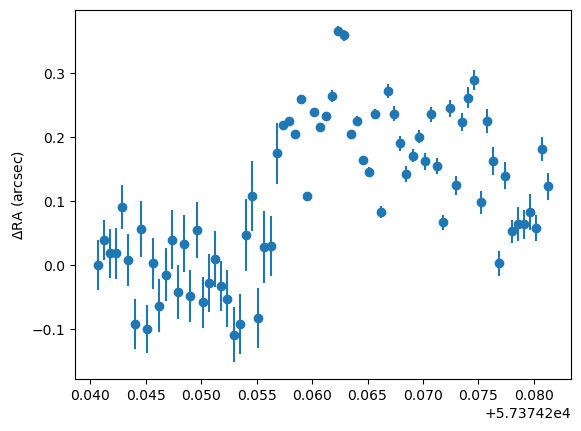

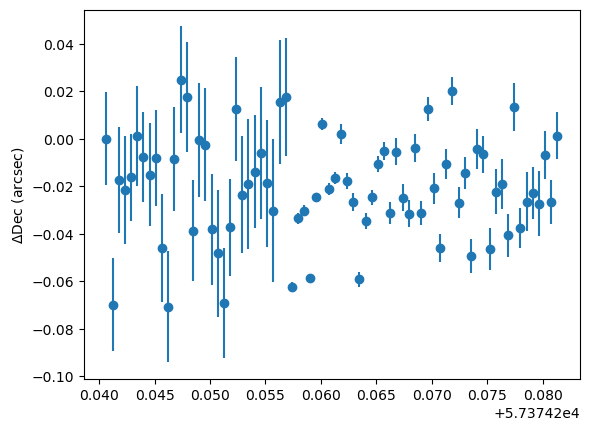

In [23]:
plt.errorbar(main_df['time'][main_df['id'] == flr_id], main_df['x_fit'][main_df['id'] == flr_id], 
             yerr = main_df['x_err'][main_df['id'] == flr_id], marker='o', ls='None')
plt.ylabel('x (pixel)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], main_df['y_fit'][main_df['id'] == flr_id], 
             yerr = main_df['y_err'][main_df['id'] == flr_id], marker='o', ls='None')
plt.ylabel('y (pixel)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], (main_df['RA'][main_df['id'] == flr_id] - 
                        main_df['RA'][main_df['id'] == flr_id].iloc[0]) * D2ARCSEC, 
             yerr = main_df['RA_ERR'][main_df['id'] == flr_id] * D2ARCSEC, marker='o', ls='None')
plt.ylabel(r'$\Delta$RA (arcsec)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], (main_df['DEC'][main_df['id'] == flr_id] - 
                        main_df['DEC'][main_df['id'] == flr_id].iloc[0]) * D2ARCSEC, 
             yerr = main_df['DEC_ERR'][main_df['id'] == flr_id] * D2ARCSEC, marker='o', ls='None')
plt.ylabel(r'$\Delta$Dec (arcsec)')
plt.show()

In [24]:
main_df

,id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fwhm_init,y_fwhm_init,x_fit,...,y_fwhm_err,npixfit,qfit,cfit,flags,RA,DEC,RA_ERR,DEC_ERR,time
0,1.0,1.0,1.0,32.860002,868.522296,21.285904,126752.984875,1.0,1.0,868.901854,...,0.019373,625.0,0.139842,0.001461,0.0,45.554966,-54.992271,0.000001,5.377676e-07,57374.240660
1,67.0,67.0,1.0,22.824020,184.676236,2398.123898,9088.540348,1.0,1.0,184.788578,...,0.069575,625.0,0.798354,0.000974,0.0,45.856575,-54.940755,0.000004,1.952583e-06,57374.240660
2,66.0,66.0,1.0,22.704307,1300.432535,2334.177144,8039.251865,1.0,1.0,1300.538688,...,0.136910,625.0,1.404182,0.001640,0.0,45.850447,-55.022310,0.000007,4.226357e-06,57374.240660
3,65.0,65.0,1.0,23.986071,1134.901937,2308.007500,11107.253667,1.0,1.0,1134.845481,...,0.042059,625.0,0.446303,0.001646,0.0,45.846829,-55.010223,0.000002,1.151464e-06,57374.240660
4,64.0,64.0,1.0,23.267743,89.050946,2290.185485,9862.451182,1.0,1.0,88.927061,...,0.057909,625.0,0.618064,0.001374,0.0,45.842770,-54.933839,0.000003,1.546420e-06,57374.240660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,25.0,25.0,1.0,30.836489,1711.013637,1002.334108,10776.370524,1.0,1.0,1713.230690,...,0.240641,625.0,2.280585,0.001066,0.0,45.681360,-55.053572,0.000013,6.532347e-06,57374.281315
6656,24.0,24.0,1.0,27.664921,1353.061647,945.537470,10435.065140,1.0,1.0,1356.854621,...,0.095976,625.0,0.870087,-0.002466,0.0,45.673733,-55.027555,0.000005,2.499945e-06,57374.281315
6657,22.0,22.0,1.0,27.925559,1215.973622,926.975891,9584.155881,1.0,1.0,1216.566541,...,0.140216,625.0,1.549302,-0.004060,0.0,45.671096,-55.017312,0.000008,3.804777e-06,57374.281315
6658,31.0,31.0,1.0,55.709088,1824.498209,1213.554383,57115.466188,1.0,1.0,1824.834737,...,0.092717,625.0,0.615803,0.000643,0.0,45.708521,-55.061596,0.000005,2.426805e-06,57374.281315


<Axes: >

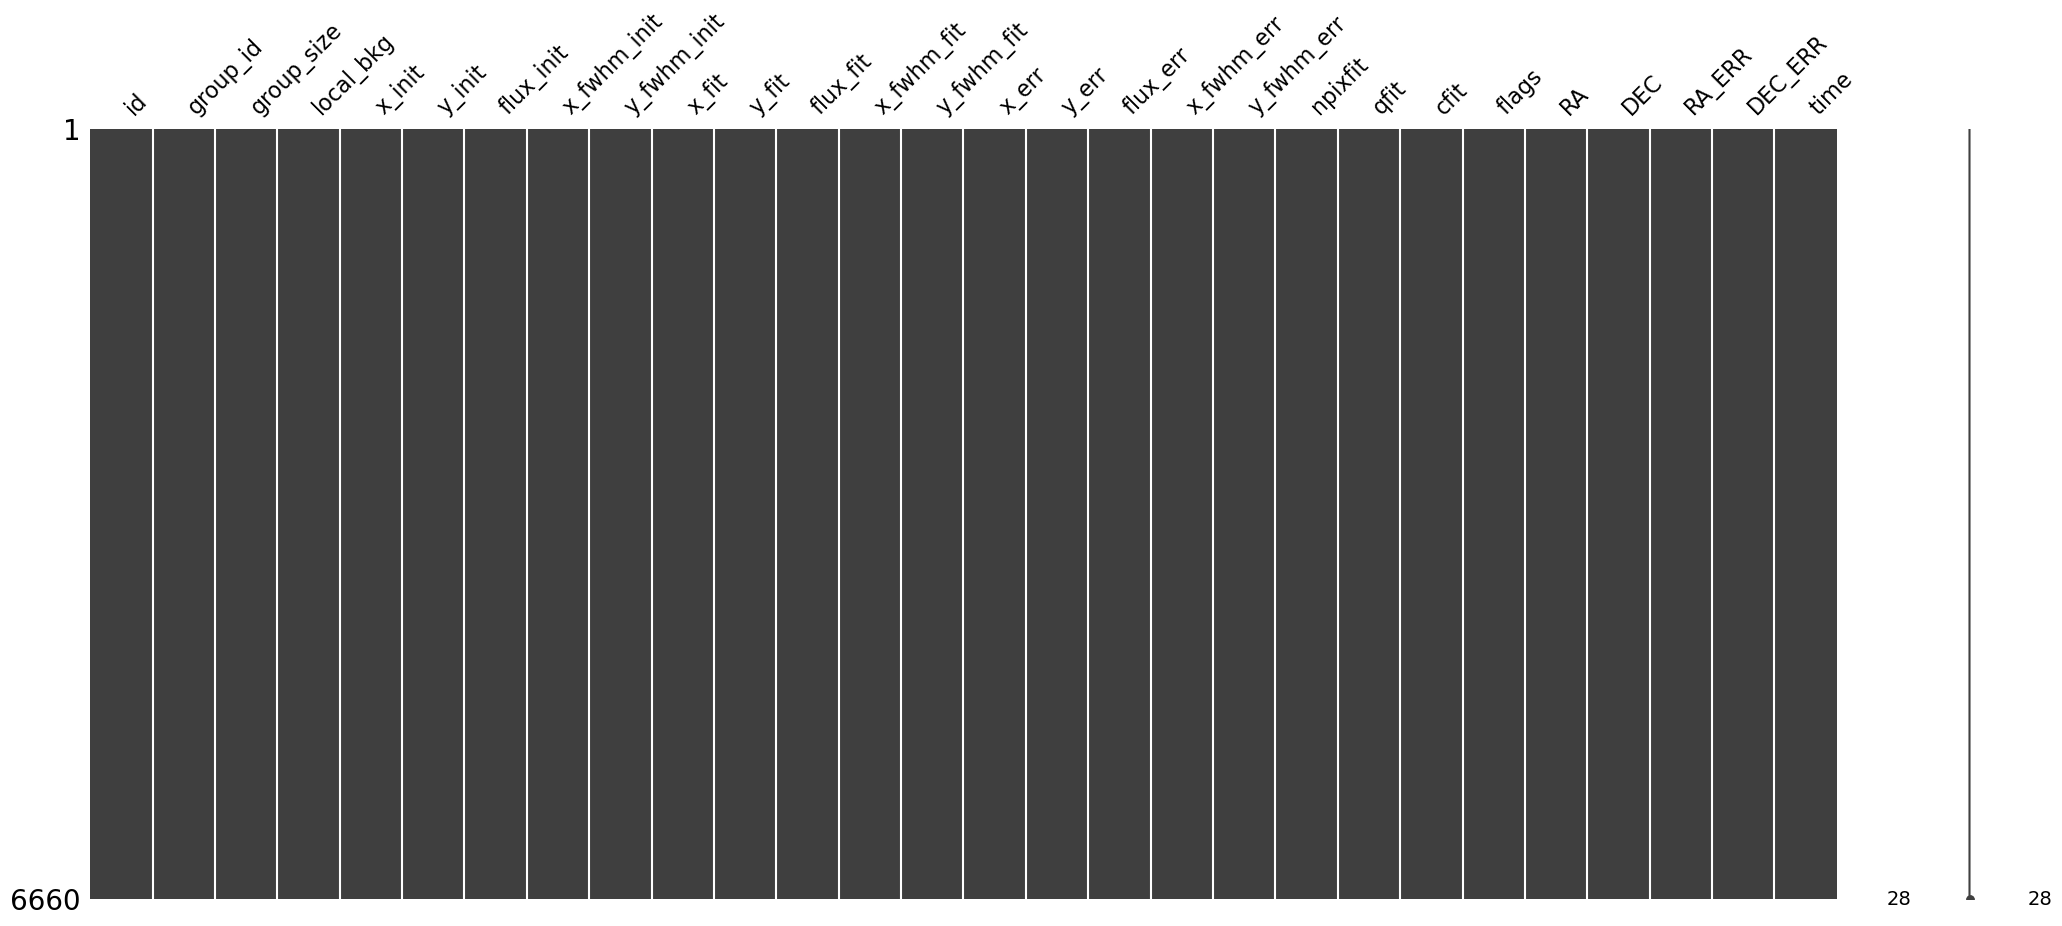

In [25]:
missno.matrix(main_df)

In [26]:
# FBB cleaning maindf 
main_df = main_df.dropna(how="all")
len(main_df)

6660

In [27]:
# FBB moved here because it uses main_df - soon you will make arrays and can use only ghose
#airmass of flare object at all epochs
flr_am = SkyCoord(ra = main_df['RA'][main_df['id'] == flr_id], dec = main_df['DEC'][main_df['id'] == flr_id], 
         unit=u.deg, obstime=Time(main_df['time'][main_df['id'] == flr_id].values, format='mjd'), 
                  location=EarthLocation.of_site('Cerro Tololo')).transform_to(AltAz).secz.value

flr_am.min(), flr_am.max()

(1.4607134302405007, 1.752918955119076)

In [28]:
#epochs when the flare star is observed
dt_sec = (main_df['time'][main_df['id'] == flr_id] - main_df['time'][main_df['id'] == flr_id].iloc[0]) * DAY2SEC
print(f"Epochs with flare star detections: {dt_sec.shape[0]}")

Epochs with flare star detections: 74


In [29]:
if SAVE:
    np.save('Outdata/dt_sec.npy', dt_sec)

### getting RA and Dec for each star and time tamp into an array

In [30]:
main_df['RA'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values

array([], dtype=float64)

In [31]:
NStars = main_df['id'].dropna().unique().shape[0]
print(f"{NStars} stars")
ras = np.zeros((NDPS, NStars)) #74 time stamps, 110 stars RA in deg
decs = np.zeros((NDPS, NStars)) #74 time stamps, 110 stars Dec in deg

for j, id in (enumerate(np.sort(main_df['id'].dropna().unique()))): #for every star
    print(f"star id {j}")
    for i, t in (enumerate(main_df['time'].dropna().unique())): #for every time stamp
        if (main_df['RA'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values).any():
            ras[i,j] = main_df['RA'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values[0]
            decs[i,j] = main_df['DEC'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values[0]
        else:
            ras[i,j] = np.nan
            decs[i,j] = np.nan
            

92 stars
star id 0
star id 1
star id 2
star id 3
star id 4
star id 5
star id 6
star id 7
star id 8
star id 9
star id 10
star id 11
star id 12
star id 13
star id 14
star id 15
star id 16
star id 17
star id 18
star id 19
star id 20
star id 21
star id 22
star id 23
star id 24
star id 25
star id 26
star id 27
star id 28
star id 29
star id 30
star id 31
star id 32
star id 33
star id 34
star id 35
star id 36
star id 37
star id 38
star id 39
star id 40
star id 41
star id 42
star id 43
star id 44
star id 45
star id 46
star id 47
star id 48
star id 49
star id 50
star id 51
star id 52
star id 53
star id 54
star id 55
star id 56
star id 57
star id 58
star id 59
star id 60
star id 61
star id 62
star id 63
star id 64
star id 65
star id 66
star id 67
star id 68
star id 69
star id 70
star id 71
star id 72
star id 73
star id 74
star id 75
star id 76
star id 77
star id 78
star id 79
star id 80
star id 81
star id 82
star id 83
star id 84
star id 85
star id 86
star id 87
star id 88
star id 89
star id 90


### getting RA and Dec uncertainties for each star and time tamp into an array

In [32]:
raerrs = np.zeros((NDPS, NStars)) # error 74 time stamps 110 stars RA uncertainties in deg
decerrs = np.zeros((NDPS, NStars)) # error 74 time stamps 110 stars Dec uncertainties in deg

# FBB you could avoid he for loop with the "in" syntax but ok
for j, id in (enumerate(np.sort(main_df['id'].dropna().unique()))): #for every star
    print(f"star id {j}")
    for i, t in (enumerate(main_df['time'].dropna().unique())): #for every time stamp
        if (main_df['RA_ERR'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values).any():
            raerrs[i,j] = main_df['RA_ERR'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values[0] 
            decerrs[i,j] = main_df['DEC_ERR'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values[0]

        else:
            raerrs[i,j] = np.nan
            decerrs[i,j] = np.nan


star id 0
star id 1
star id 2
star id 3
star id 4
star id 5
star id 6
star id 7
star id 8
star id 9
star id 10
star id 11
star id 12
star id 13
star id 14
star id 15
star id 16
star id 17
star id 18
star id 19
star id 20
star id 21
star id 22
star id 23
star id 24
star id 25
star id 26
star id 27
star id 28
star id 29
star id 30
star id 31
star id 32
star id 33
star id 34
star id 35
star id 36
star id 37
star id 38
star id 39
star id 40
star id 41
star id 42
star id 43
star id 44
star id 45
star id 46
star id 47
star id 48
star id 49
star id 50
star id 51
star id 52
star id 53
star id 54
star id 55
star id 56
star id 57
star id 58
star id 59
star id 60
star id 61
star id 62
star id 63
star id 64
star id 65
star id 66
star id 67
star id 68
star id 69
star id 70
star id 71
star id 72
star id 73
star id 74
star id 75
star id 76
star id 77
star id 78
star id 79
star id 80
star id 81
star id 82
star id 83
star id 84
star id 85
star id 86
star id 87
star id 88
star id 89
star id 90
star id 9

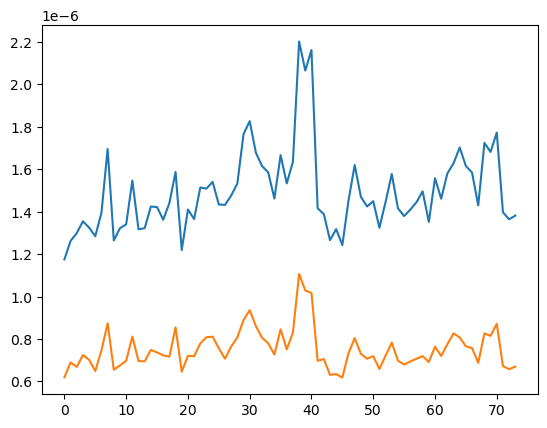

In [33]:
plt.plot(raerrs[:,flr_id])
plt.plot(decerrs[:,flr_id])
#print("errors in RA and DEC are suspiciously similar... FBB does not understand why really")

In [34]:
len(ras[:,flr_id])

74

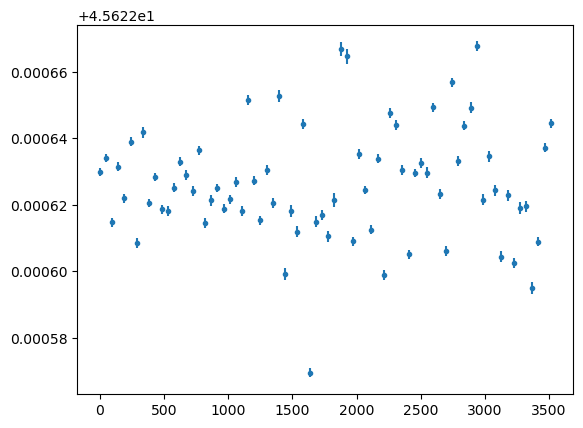

<ErrorbarContainer object of 3 artists>

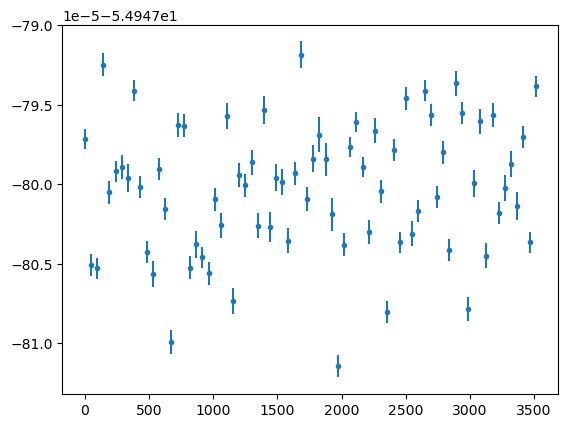

In [35]:
plt.errorbar(dt_sec, ras[:,flr_id], yerr=raerrs[:,flr_id], fmt='.')
plt.show()
plt.errorbar(dt_sec,decs[:,flr_id], yerr=decerrs[:,flr_id], fmt='.')

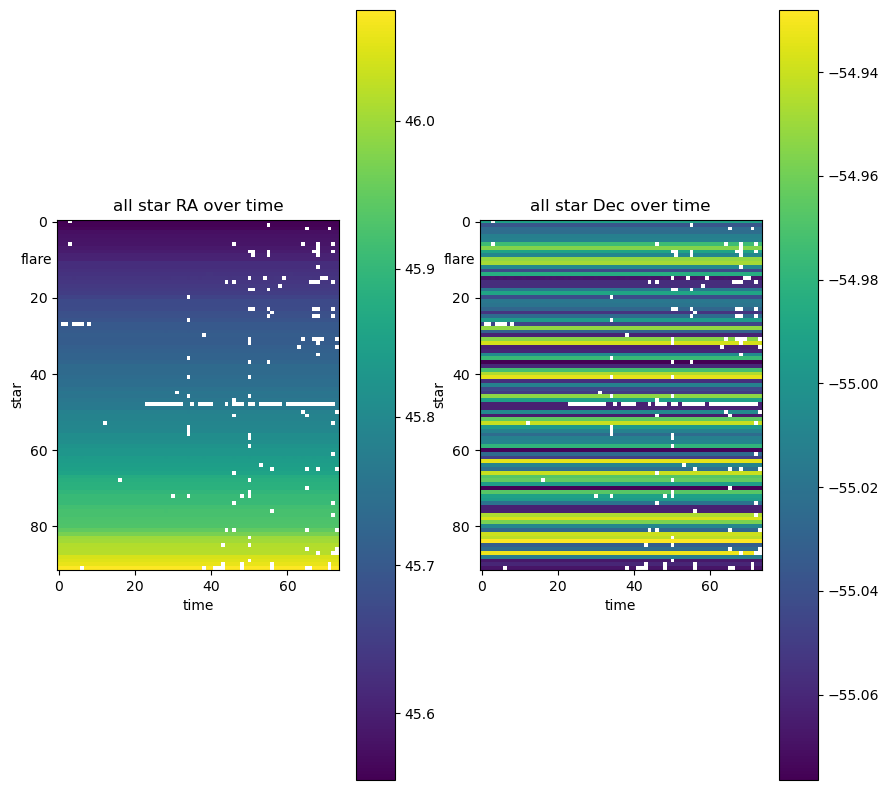

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(ras.T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA over time")
axs[0].annotate("flare", (-0.6,flr_id), xytext=(-10, flr_id), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(decs.T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,flr_id), xytext=(-10, flr_id), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec over time");


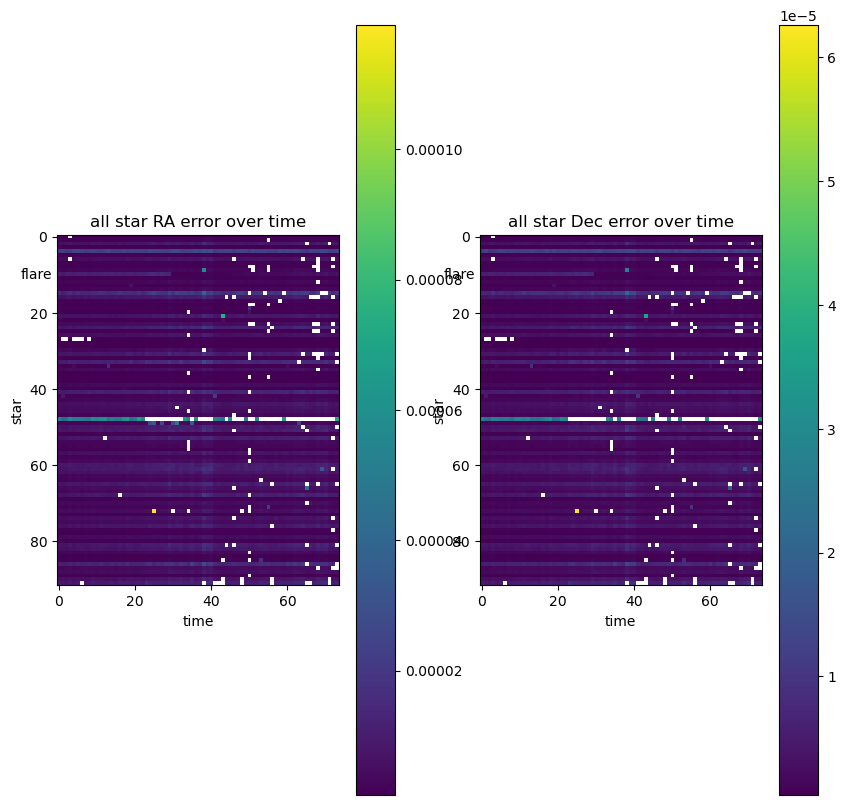

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(raerrs.T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA error over time")
axs[0].annotate("flare", (-0.6,flr_id), xytext=(-10, flr_id), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(decerrs.T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,flr_id), xytext=(-10, flr_id), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec error over time");


### relative position for each star (compared to first time stamp)

In [38]:
# FBB moved here and used throughout instead of repeatedly subtracting the last epoch. Also this is a vectorizable operation! no need for for loop
#FBB convert to arcsec here once and for all isntead of redoing below a bunch of times
shift_ras = (ras - ras[0,:]) * D2ARCSEC# in arcsec
shift_decs = (decs - decs[0,:]) * D2ARCSEC# in arcsec

shift_ras.shape, shift_decs.shape

((74, 92), (74, 92))

### uncertainty in arcsec for each star (compared to first time stamp)

In [39]:
# FBB I think you do not need to add the error in quadrature because you just want to have a reference? 
shift_raerrs = raerrs * D2ARCSEC #np.sqrt(raerrs **2 + raerrs[0,:] **2) * D2ARCSEC
shift_decerrs = decerrs * D2ARCSEC #np.sqrt(decerrs**2 +  decerrs[0,:]**2) * D2ARCSEC

shift_raerrs.shape, shift_decerrs.shape

((74, 92), (74, 92))

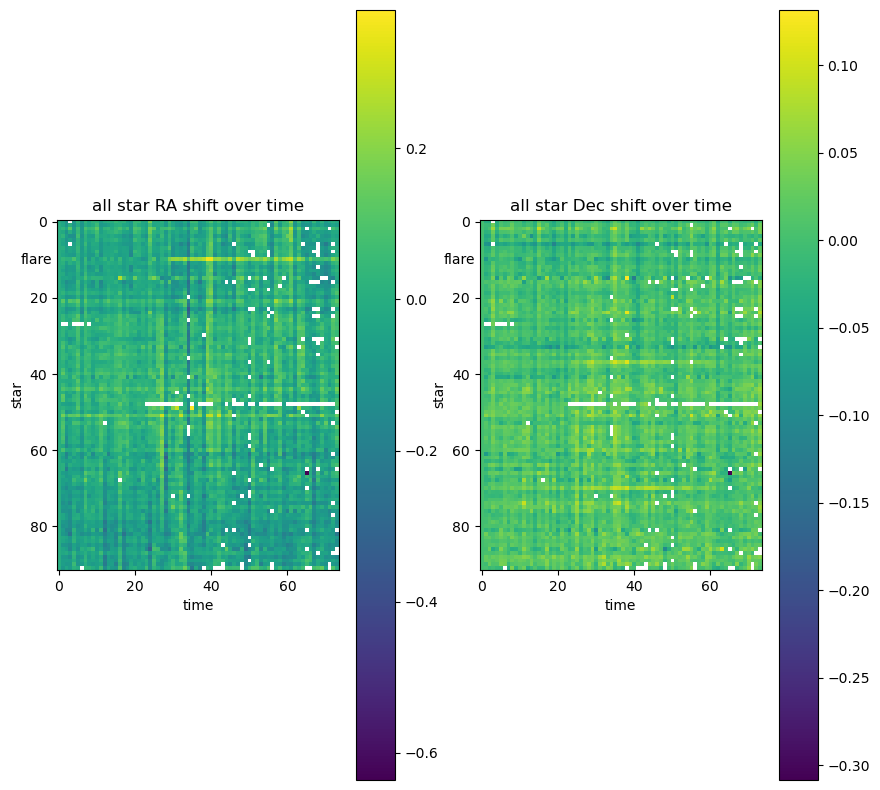

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(shift_ras.T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA shift over time")
axs[0].annotate("flare", (-0.6, flr_id), xytext=(-10, flr_id), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(shift_decs.T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6, flr_id), xytext=(-10, flr_id), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec shift over time");


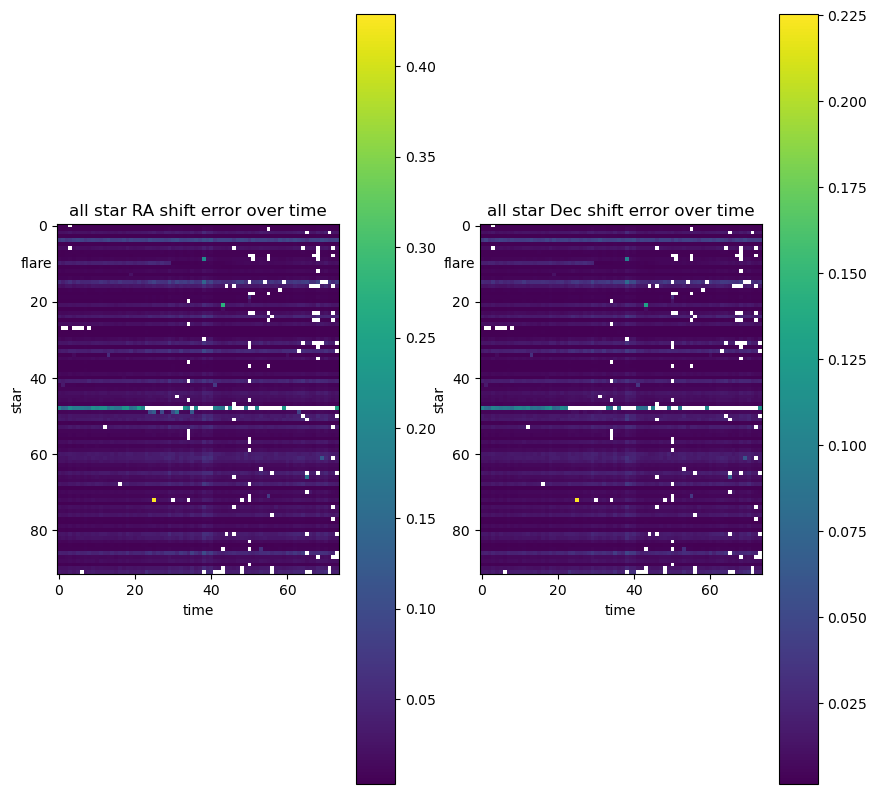

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(shift_raerrs.T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA shift error over time")
axs[0].annotate("flare", (-0.6,flr_id), xytext=(-10, flr_id), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(shift_decerrs.T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,flr_id), xytext=(-10, flr_id), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec shift error over time");


In [42]:
# FBB new array that does not contain flare star
ras_noflare = np.delete(ras, FLAREINDX, 1)
decs_noflare = np.delete(decs, FLAREINDX, 1)
ras_noflare.shape, decs_noflare.shape

((74, 91), (74, 91))

In [43]:
# FBB new array that does not contain flare star
shift_ras_noflare = np.delete(shift_ras, FLAREINDX, 1)
shift_decs_noflare = np.delete(shift_decs, FLAREINDX, 1)
shift_ras_noflare.shape, shift_decs_noflare.shape

((74, 91), (74, 91))

In [44]:
# FBB new array that does not contain flare star
raerrs_noflare = np.delete(raerrs, FLAREINDX, 1)
decerrs_noflare = np.delete(decerrs, FLAREINDX, 1)
raerrs_noflare.shape, decerrs_noflare.shape

((74, 91), (74, 91))

In [45]:
# FBB new array that does not contain flare star
shift_raerrs_noflare = np.delete(shift_raerrs, FLAREINDX, 1)
shift_decerrs_noflare = np.delete(shift_decerrs, FLAREINDX, 1)
shift_raerrs_noflare.shape, shift_decerrs_noflare.shape

((74, 91), (74, 91))

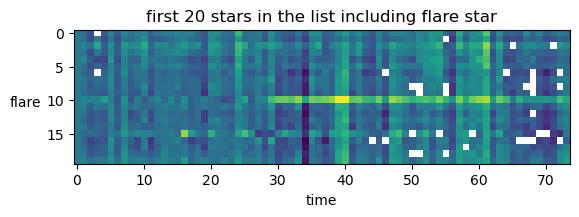

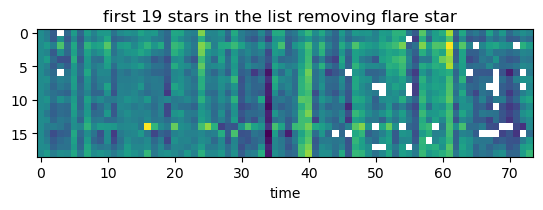

In [46]:
#making sure I removed the flare star: it shows up obviously with a change near epoch 30
plt.imshow(shift_ras[:, :20].T)
plt.xlabel("time")
plt.title("first 20 stars in the list including flare star")
plt.annotate("flare", (1,flr_id), xytext=(-10, flr_id), color="k")

plt.show()
plt.imshow(shift_ras_noflare[:, :19].T)
plt.title("first 19 stars in the list removing flare star  ")
plt.xlabel("time");


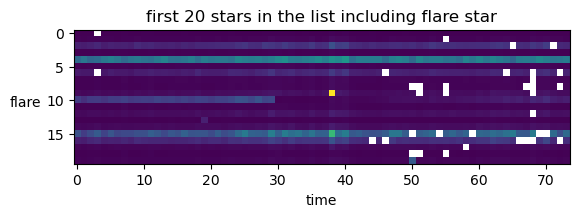

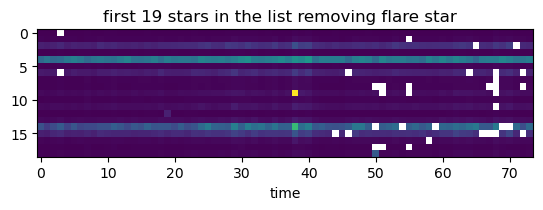

In [47]:
#making sure I removed the flare star: it shows up obviously with a change near epoch 30
plt.imshow(shift_raerrs[:, :20].T)
plt.xlabel("time")
plt.title("first 20 stars in the list including flare star")
plt.annotate("flare", (1,flr_id), xytext=(-10, flr_id), color="k")

plt.show()
plt.imshow(shift_raerrs_noflare[:, :19].T)
plt.title("first 19 stars in the list removing flare star  ")
plt.xlabel("time");

In [48]:
# FBB make an array for RA of flare and dec of flare only
shift_ras_flare = shift_ras[:,FLAREINDX] 
shift_decs_flare = shift_decs[:,FLAREINDX]
# FBB make an array for RA of flare and dec of flare only
shift_raerrs_flare = shift_raerrs[:,FLAREINDX]
shift_decerrs_flare = shift_decerrs[:,FLAREINDX]
shift_ras_flare.shape, shift_decs_flare.shape, shift_raerrs_flare.shape, shift_decerrs_flare.shape

((74,), (74,), (74,), (74,))

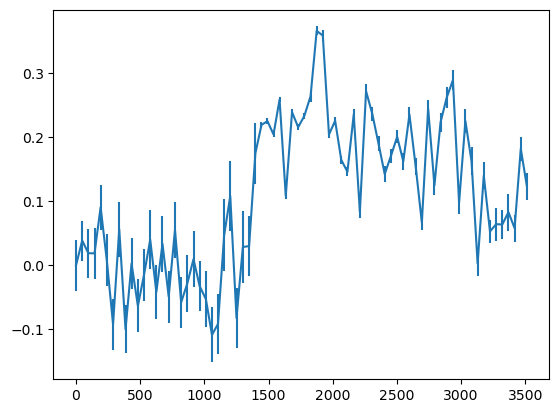

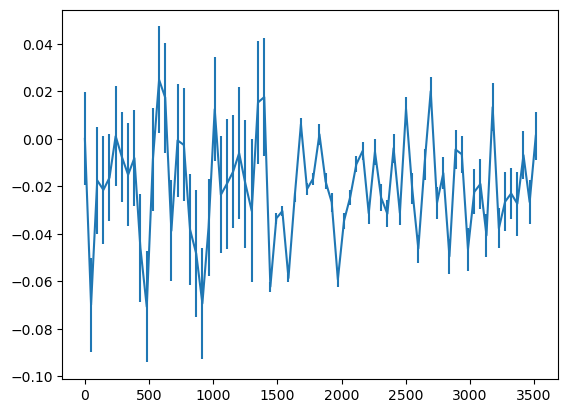

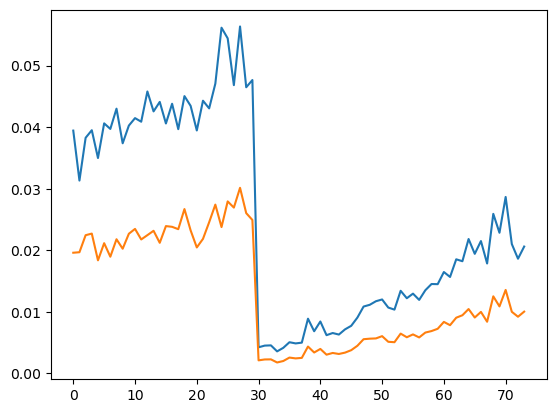

In [49]:
plt.errorbar(dt_sec, shift_ras_flare, yerr=shift_raerrs_flare)
plt.show()
plt.errorbar(dt_sec, shift_decs_flare, yerr=shift_decerrs_flare)
plt.show()
plt.plot(shift_raerrs_flare)
plt.plot(shift_decerrs_flare)
plt.show()

In [50]:
if SAVE:
    np.save('Outdata/ras.npy', ras)
    np.save('Outdata/decs.npy', decs)

    np.save('Outdata/ra_change.npy', shift_ras)
    np.save('Outdata/dec_chane.npy', shift_decs)

In [51]:
if SAVE:
    np.save('Outdata/raerrs.npy', raerrs)
    np.save('Outdata/decerrs.npy', decerrs)

In [52]:
#only not nan values
select = np.isnan(shift_ras_noflare).sum(axis=0)==0
shift_ras_noflare[:, select].shape

(74, 34)

In [53]:
# FBB use shiftarray instead of subtracting first epoch again
dra_mean = np.nanmean(shift_ras_noflare, axis=1) 
ddec_mean = np.nanmean(shift_decs_noflare, axis=1) 
dra_mean_onlyfullydetected = np.mean(shift_ras_noflare[:, select], axis=1) #only stars available in all obs
ddec_mean_onlyfullydetected = np.mean(shift_ras_noflare[:, select], axis=1) #only stars available in all obs

dra_std = np.nanstd(shift_ras_noflare, axis=1) 
ddec_std = np.nanstd(shift_decs_noflare, axis=1) 
dra_std_onlyfullydetected = np.std(shift_ras_noflare[:, select], axis=1) #only stars available in all obs
ddec_std_onlyfullydetected = np.std(shift_decs_noflare[:, select], axis=1)  #only stars available in all obs
                    

In [54]:
#standard deviation of each star error overall
raerr_std = np.nanstd(raerrs, axis=1) 
decerr_std = np.nanstd(decerrs, axis=1) 

#error as standard deviation of the segment for the flare star
raunc_before = np.nanstd(shift_ras_flare[:20])
raunc_after  = np.nanstd(shift_ras_flare[30:])
decunc_before = np.nanstd(shift_ras_flare[:20])
decunc_after  = np.nanstd(shift_ras_flare[30:])
#new uncertainty arrays for flare star
raunc = np.array([raunc_before]*23 + [raunc_after]*(len(shift_ras_flare)-23))
decunc = np.array([decunc_before]*23 + [decunc_after]*(len(shift_ras_flare)-23))

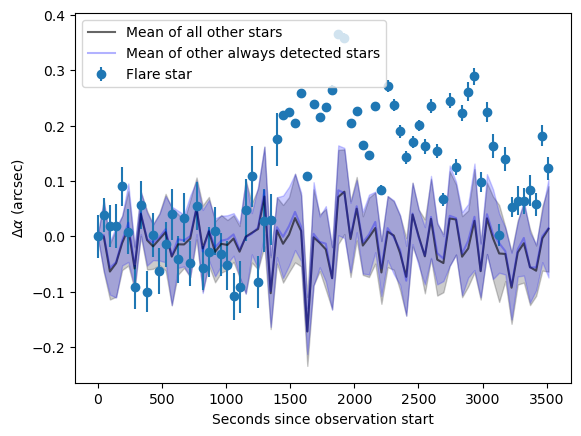

In [55]:
plt.errorbar(dt_sec, shift_ras_flare[t_index], 
             yerr = shift_raerrs_flare[t_index], marker='o', ls='None', label='Flare star')
#plt.errorbar(dt_sec, shift_ras_flare[t_index], 
#             yerr = raunc[t_index], color="k", alpha=0.5,
#             marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, dra_mean[t_index], c='k', alpha=0.6, label='Mean of all other stars')
plt.fill_between(dt_sec, dra_mean[t_index] + dra_std[t_index], 
                 dra_mean[t_index] - dra_std[t_index], color='k', alpha=0.2)
plt.ylabel(r'$\Delta\alpha$ (arcsec)')
plt.xlabel('Seconds since observation start')

plt.plot(dt_sec, dra_mean_onlyfullydetected[t_index], c='b', alpha=0.3, label='Mean of other always detected stars')
plt.fill_between(dt_sec, dra_mean_onlyfullydetected[t_index] + dra_std_onlyfullydetected[t_index], 
                 dra_mean_onlyfullydetected[t_index] - dra_std_onlyfullydetected[t_index], color='b', 
                 alpha=0.2)
plt.legend()

plt.show()


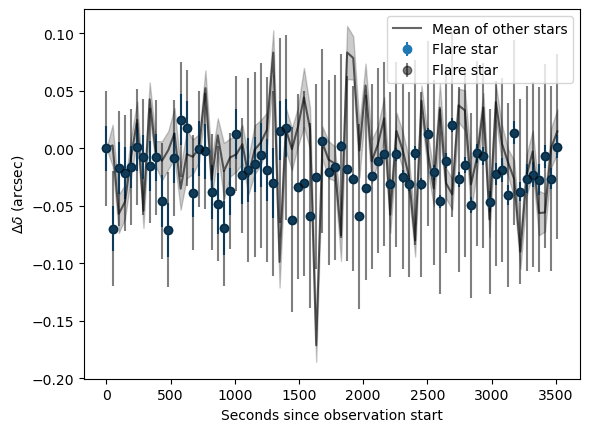

In [56]:

plt.errorbar(dt_sec, shift_decs_flare[t_index], 
             yerr = shift_decerrs_flare[t_index], marker='o', ls='None', label='Flare star')
plt.errorbar(dt_sec, shift_decs_flare[t_index], 
             yerr = decunc[t_index], color='k', alpha=0.5,marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, ddec_mean_onlyfullydetected[t_index], c='k', alpha=0.6, label='Mean of other stars')
plt.fill_between(dt_sec, ddec_mean_onlyfullydetected[t_index] + ddec_std_onlyfullydetected[t_index], 
                 ddec_mean_onlyfullydetected[t_index] - ddec_std_onlyfullydetected[t_index], color='k', alpha=0.2)
plt.xlabel('Seconds since observation start')
plt.ylabel(r'$\Delta\delta$ (arcsec)')
plt.legend()
plt.show()

In [57]:
len(shift_raerrs_flare), len(dt_sec)

(74, 74)

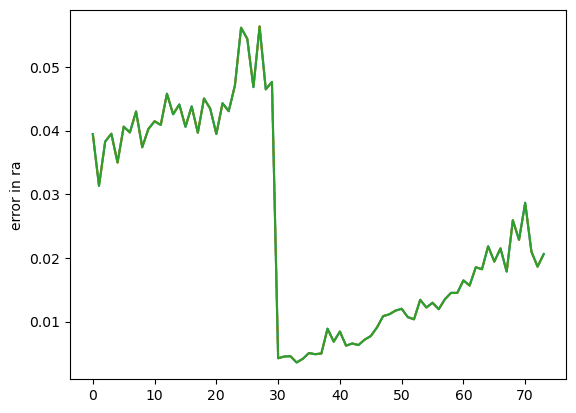

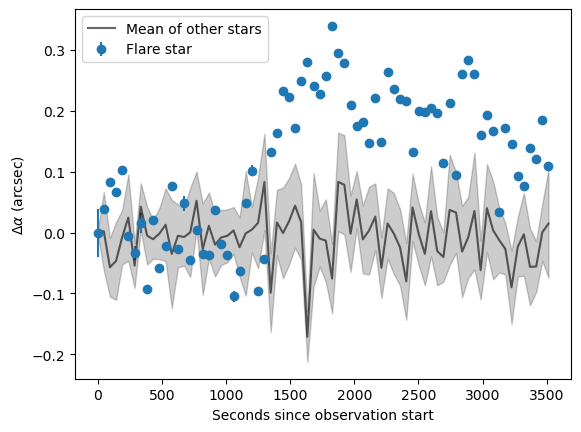

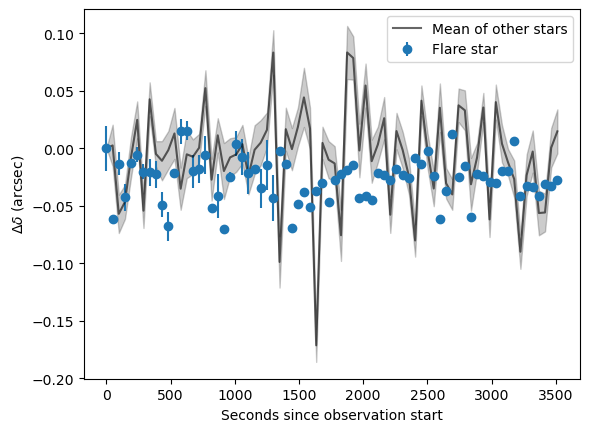

In [58]:
#using only stars with complete coverage at all epochs
err = shift_raerrs_flare, shift_decerrs_flare
plt.plot(raerrs[:,FLAREINDX] * D2ARCSEC)
plt.plot(err[0], '--')
#err = raunc, decunc
plt.plot(err[0])
plt.ylabel("error in ra")
plt.figure()
plt.errorbar(dt_sec, shift_ras_flare[t_index] - dra_mean[t_index],
             yerr = np.sqrt(err[0][t_index]**2 
                            - dra_std[t_index]**2) , marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, dra_mean_onlyfullydetected[t_index], c='k', alpha=0.6, label='Mean of other stars')
plt.fill_between(dt_sec, dra_mean_onlyfullydetected[t_index] + dra_std_onlyfullydetected[t_index], 
                 dra_mean_onlyfullydetected[t_index] - dra_std_onlyfullydetected[t_index], color='k', alpha=0.2)
plt.ylabel(r'$\Delta\alpha$ (arcsec)')
plt.xlabel('Seconds since observation start')
plt.legend()
plt.show()

plt.errorbar(dt_sec, shift_decs_flare[t_index] - ddec_mean[t_index],
             yerr = np.sqrt(err[1][t_index]**2 - ddec_std[t_index] **2), marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, ddec_mean_onlyfullydetected[t_index], c='k', alpha=0.6, label='Mean of other stars')
plt.fill_between(dt_sec, ddec_mean_onlyfullydetected[t_index] + ddec_std_onlyfullydetected[t_index], 
                 ddec_mean_onlyfullydetected[t_index] - ddec_std_onlyfullydetected[t_index], color='k', alpha=0.2)
plt.xlabel('Seconds since observation start')
plt.ylabel(r'$\Delta\delta$ (arcsec)')
plt.legend()
plt.show()

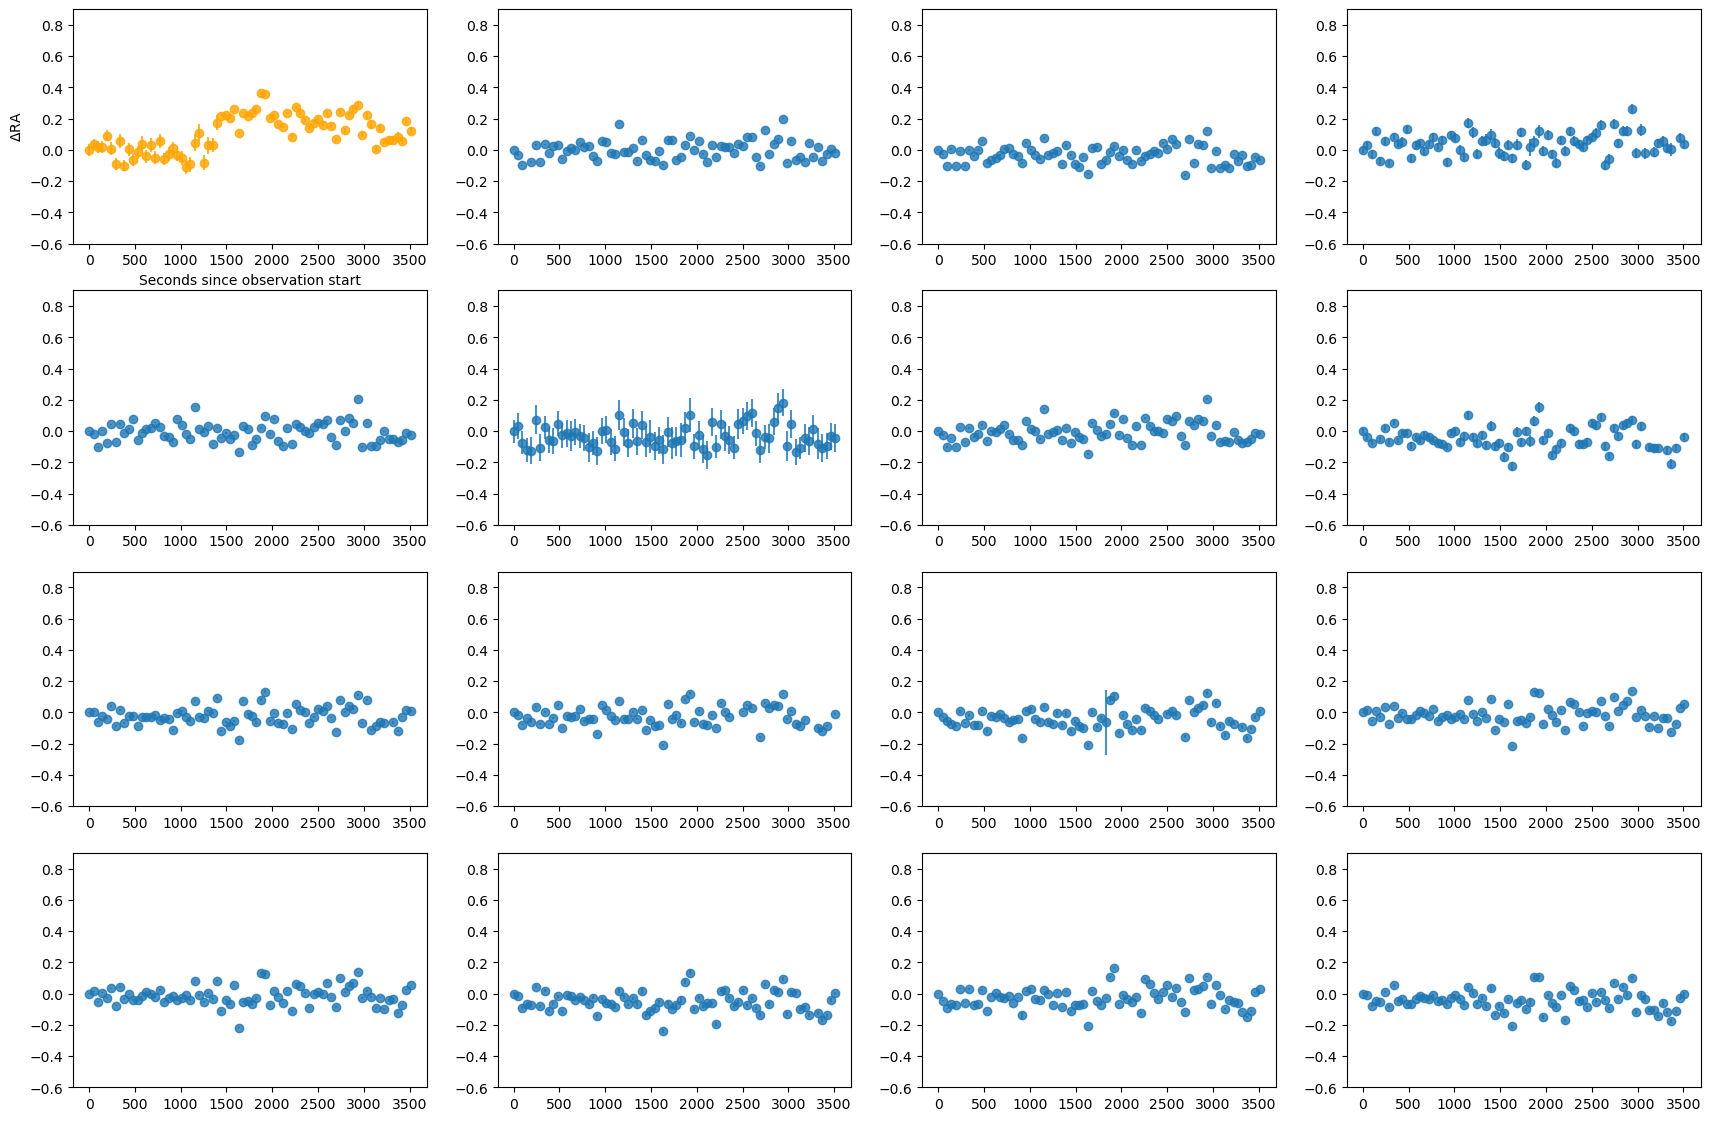

In [59]:
# FBB use shiftarrays which are already relative position and already in arcsec
fig, ax = plt.subplots(4,4, figsize=(21,14))

ax[0][0].errorbar(dt_sec, shift_ras[:,flr_id-1][t_index], yerr=err[0][t_index], color='orange', ls='None', marker='o', alpha=0.8)

ax[0][0].set_ylim(-0.6,0.9)
ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel(r'$\Delta$RA')

for i, subax in enumerate(ax.flatten()[1:]):
    if i == flr_id-1:
        i += 1
    subax.errorbar(dt_sec, shift_ras[:,i][t_index], yerr=shift_raerrs[:,i][t_index], ls='None', marker='o', alpha=0.8)
    subax.set_ylim(-0.6,0.9)

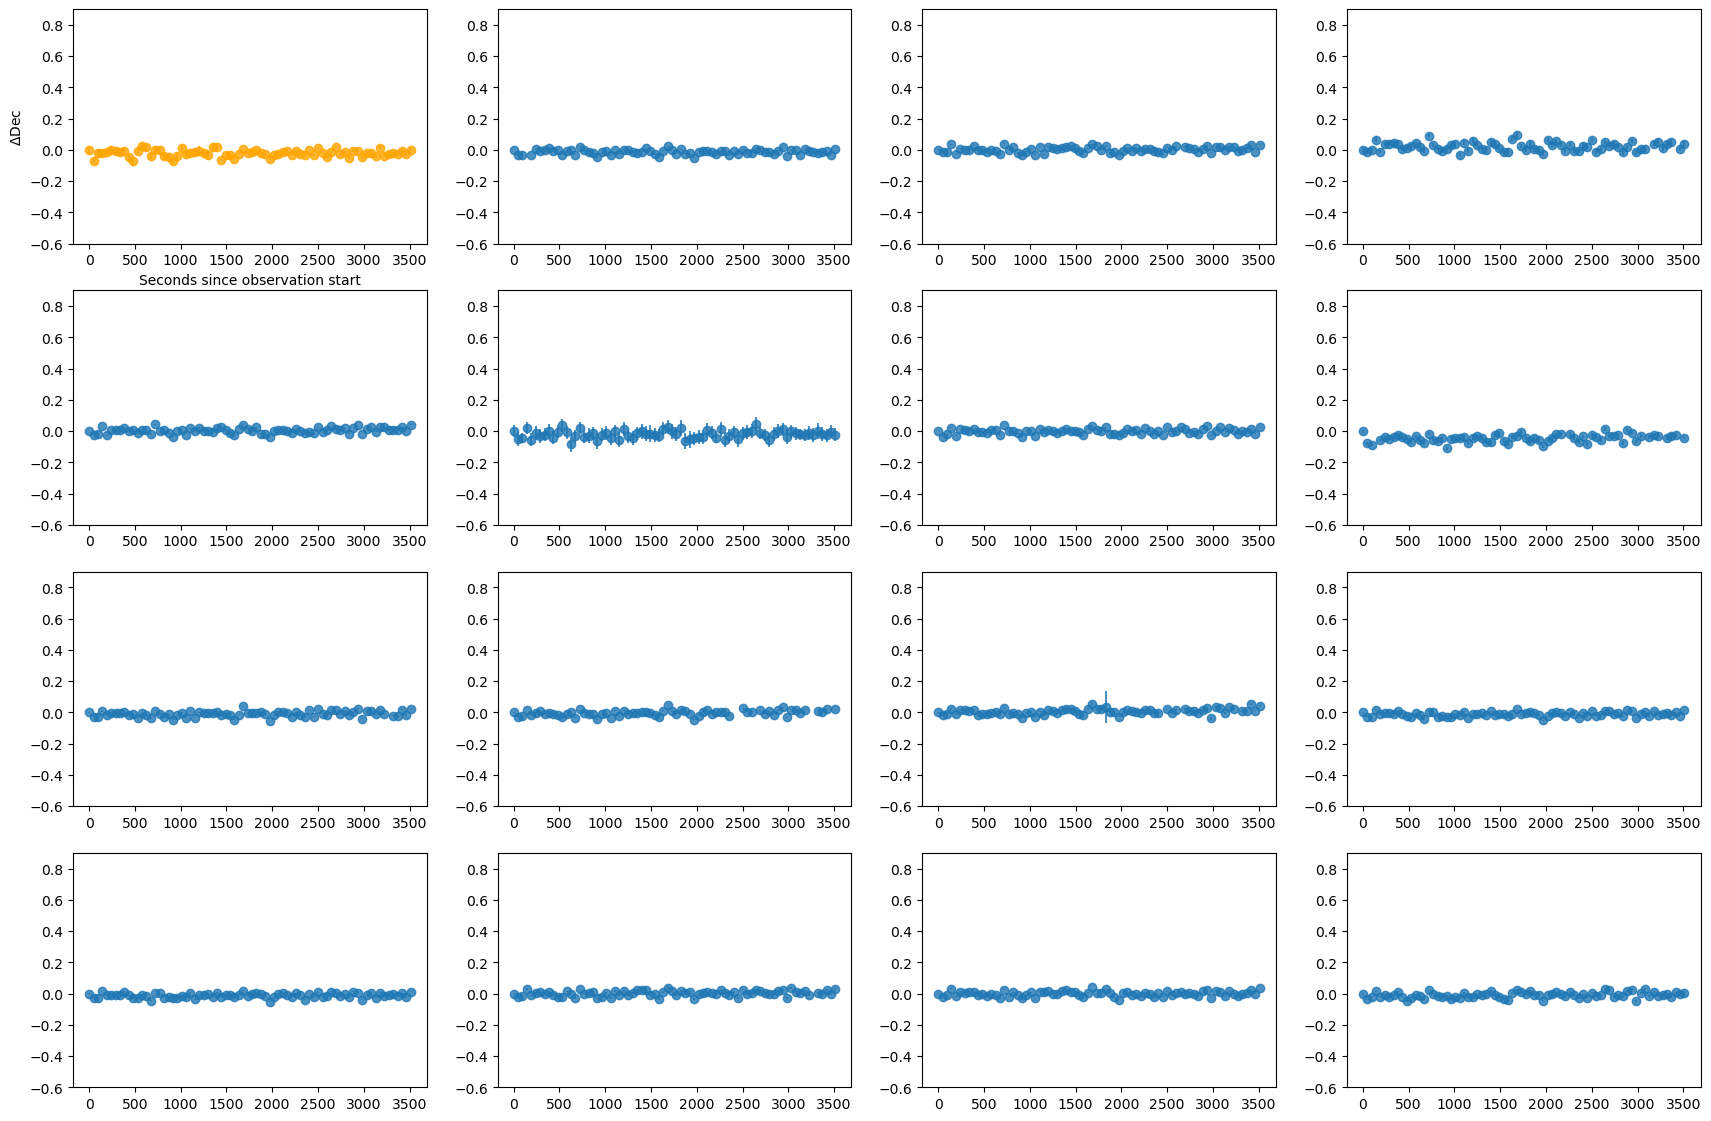

In [60]:
# FBB use shiftarrays which are already relative position and already in arcsec
fig, ax = plt.subplots(4,4, figsize=(21,14))

ax[0][0].errorbar(dt_sec, shift_decs[:,flr_id-1][t_index], yerr=err[1][t_index], color='orange', ls='None', marker='o', alpha=0.8)

ax[0][0].set_ylim(-0.6,0.9)
ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel(r'$\Delta$Dec')

for i, subax in enumerate(ax.flatten()[1:]):
    if i == flr_id-1:
        i += 1
    subax.errorbar(dt_sec, shift_decs[:,i][t_index], yerr=shift_decerrs[:,i][t_index], ls='None', marker='o', alpha=0.8)
    subax.set_ylim(-0.6,0.9)

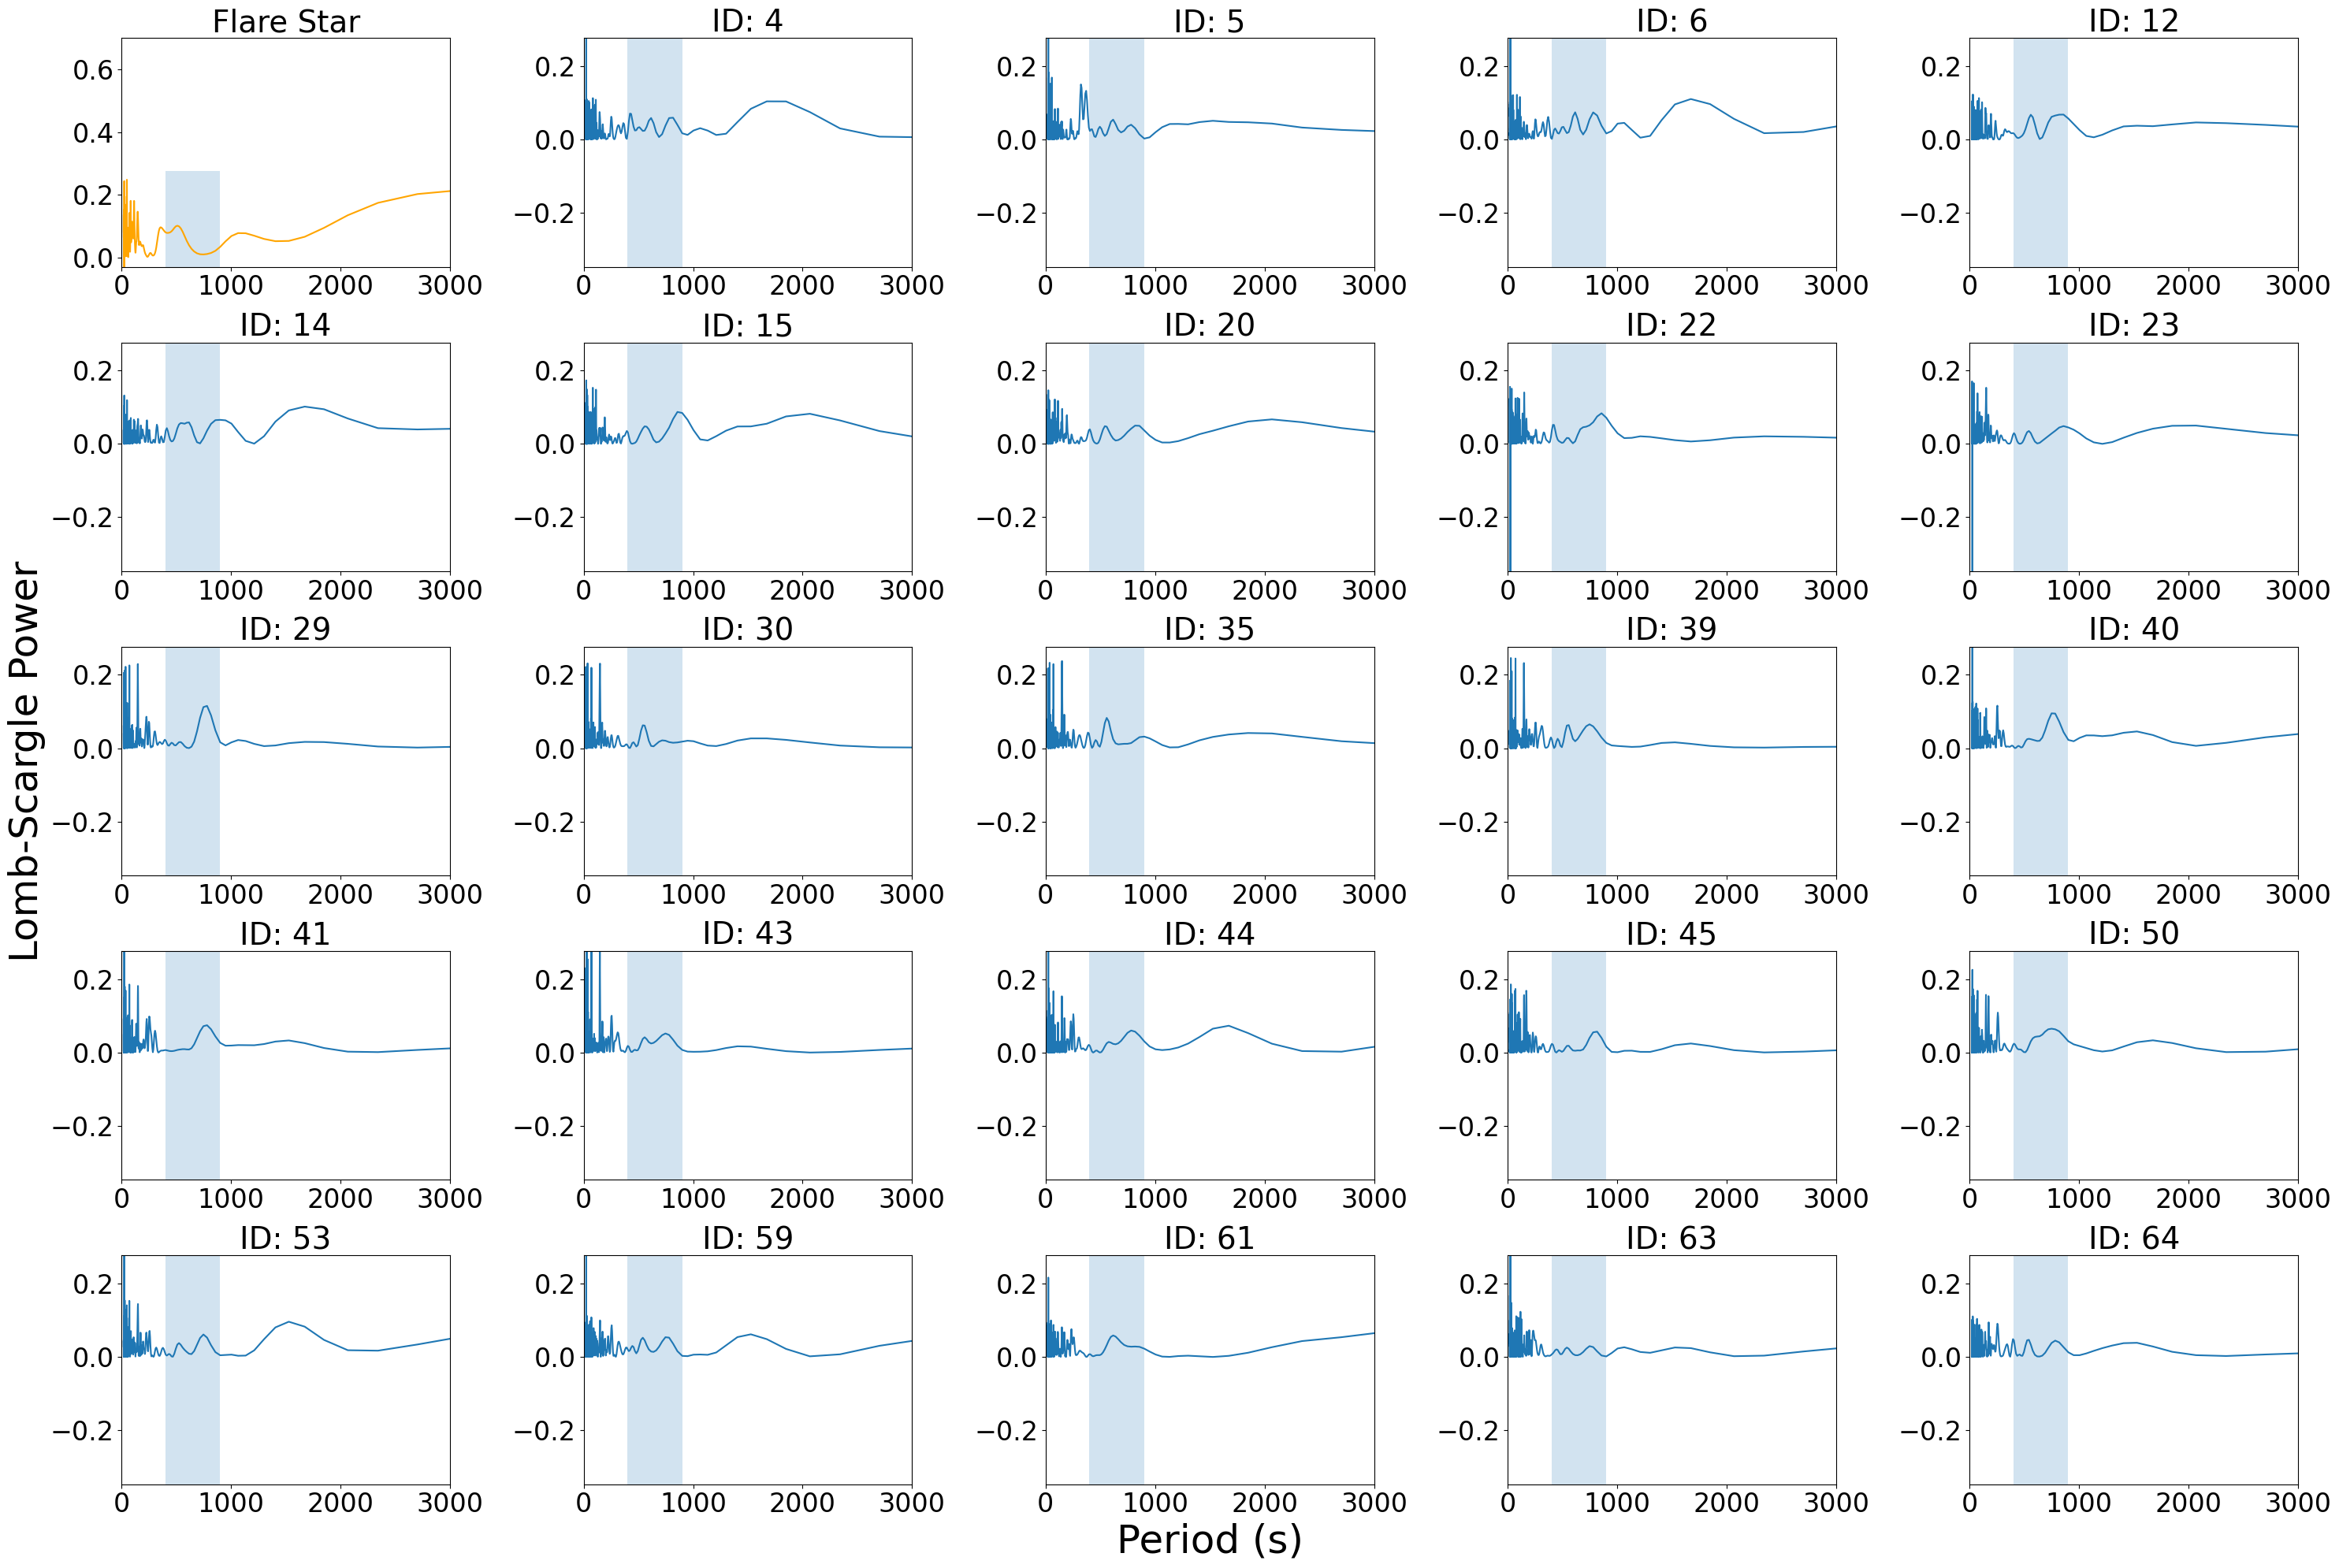

In [61]:
fig, ax = plt.subplots(5,5, figsize=(30,20))

freq, pow = LombScargle(dt_sec, shift_ras[:,flr_id-1][t_index], err[0][t_index]).autopower()

ax.flatten()[0].plot(1/freq,pow, c='orange')
ax.flatten()[0].set_xlim(0,3000)

c = 0

for i in range(1,len(ax.flatten())):

    freq, pow = LombScargle(dt_sec, shift_ras[:,c][t_index], shift_raerrs[:,c][t_index]).autopower()

    while (np.isnan(pow)).any():
        c += 1
        if c == flr_id - 1:
            c += 1
        freq, pow = LombScargle(dt_sec, shift_ras[:,c][t_index], shift_raerrs[:,c][t_index]).autopower()

    ax.flatten()[i].plot(1/freq, pow)
    ax.flatten()[i].set_xlim(0,3000)
    ax.flatten()[i].set_ylim(ax.flatten()[0].get_ylim())

    if i == 22:
        ax.flatten()[i].set_xlabel('Period (s)', fontsize=36)
    if i == 10:
        ax.flatten()[i].set_ylabel('Lomb-Scargle Power', fontsize=36)

    ax.flatten()[i].set_title('ID: {}'.format(c+1), fontsize=28)
    c += 1

for a in ax.flatten():
    a.tick_params(axis='both', labelsize=24)
    a.fill_betweenx(y = [a.get_ylim()[0], a.get_ylim()[1]], x1=400, x2=900, alpha=0.2)

ax.flatten()[0].set_ylim(-0.03, 0.7)
ax.flatten()[0].set_title('Flare Star', fontsize=28)

fig.tight_layout()

plt.savefig('Figures/dparffts.png', dpi=300, bbox_inches='tight')

## Converting $\alpha, \delta$ to $d_{\parallel}$

In [62]:
shift_ras.shape, shift_decs.shape, times.shape

((74, 92), (74, 92), (74,))

In [63]:
#Concat flare arrays to top 
'''
flr_ras = np.zeros_like(ras[:,0])
flr_decs = np.zeros_like(decs[:,0])
flr_raerrs = np.zeros_like(ras[:,0])
flr_decerrs = np.zeros_like(decs[:,0])

c = 0

for i, t in enumerate(times):
    
    if t_index[i]:

        flr_ras[i] = main_df['RA'][main_df['id'] == flr_id].iloc[c]
        flr_decs[i] = main_df['DEC'][main_df['id'] == flr_id].iloc[c]
        flr_raerrs[i] = main_df['RA_ERR'][main_df['id'] == flr_id].iloc[c]
        flr_decerrs[i] = main_df['DEC_ERR'][main_df['id'] == flr_id].iloc[c]
        c += 1
    else:

        flr_ras[i] = np.nan
        flr_decs[i] = np.nan
        flr_raerrs[i] = np.nan
        flr_decerrs[i] = np.nan

ras = np.concatenate((flr_ras[:,np.newaxis], ras), axis=1)
decs = np.concatenate((flr_decs[:,np.newaxis], decs), axis=1)
raerrs = np.concatenate((flr_raerrs[:,np.newaxis], raerrs), axis=1)
decerrs = np.concatenate((flr_decerrs[:,np.newaxis], decerrs), axis=1)
'''

"\nflr_ras = np.zeros_like(ras[:,0])\nflr_decs = np.zeros_like(decs[:,0])\nflr_raerrs = np.zeros_like(ras[:,0])\nflr_decerrs = np.zeros_like(decs[:,0])\n\nc = 0\n\nfor i, t in enumerate(times):\n    \n    if t_index[i]:\n\n        flr_ras[i] = main_df['RA'][main_df['id'] == flr_id].iloc[c]\n        flr_decs[i] = main_df['DEC'][main_df['id'] == flr_id].iloc[c]\n        flr_raerrs[i] = main_df['RA_ERR'][main_df['id'] == flr_id].iloc[c]\n        flr_decerrs[i] = main_df['DEC_ERR'][main_df['id'] == flr_id].iloc[c]\n        c += 1\n    else:\n\n        flr_ras[i] = np.nan\n        flr_decs[i] = np.nan\n        flr_raerrs[i] = np.nan\n        flr_decerrs[i] = np.nan\n\nras = np.concatenate((flr_ras[:,np.newaxis], ras), axis=1)\ndecs = np.concatenate((flr_decs[:,np.newaxis], decs), axis=1)\nraerrs = np.concatenate((flr_raerrs[:,np.newaxis], raerrs), axis=1)\ndecerrs = np.concatenate((flr_decerrs[:,np.newaxis], decerrs), axis=1)\n"

In [64]:
# converts celestial coordinates to PA - uses RA DEC RAerror and Dec error
pa_arr = np.zeros_like(ras)
delpa_arr = np.zeros_like(ras)

for i in range(ras.shape[0]):
    for j in range(ras.shape[1]):
        pa_arr[i][j], delpa_arr[i][j] = celest_to_pa(ras[i,j], decs[i,j], delra = raerrs[i][j], 
                                                     deldec = decerrs[i][j],
                                                     time = Time(times[i], format='mjd'), 
                                                     loc = EarthLocation.of_site('Cerro Tololo'))

pa_arr_noflare = np.delete(pa_arr, FLAREINDX, 1)
delpa_arr_noflare = np.delete(delpa_arr, FLAREINDX, 1)
pa_arr.shape, delpa_arr.shape, pa_arr_noflare.shape, delpa_arr_noflare.shape

((74, 92), (74, 92), (74, 91), (74, 91))

In [162]:
dpar_arr = np.zeros_like(ras)
deldpar_arr = np.zeros_like(ras)
ddra_arr = np.zeros_like(ras)
dddec_arr = np.zeros_like(ras)
ddpar_arr = np.zeros_like(ras)


for t in range(shift_ras.shape[0]): #tim
    for s in range(shift_ras.shape[1]): #star
        if s == FLAREINDX:
            dpar_arr[t][s], deldpar_arr[t][s], ddra_arr[t][s], dddec_arr[t][s], ddpar_arr[t][s] = dpar(shift_ras[t,s] / 3600, shift_decs[t,s] / 3600, 
                                                                                                       pa_arr[t,s], 
                                delra = np.sqrt(err[0][t]**2 + err[0][0]**2) / D2ARCSEC, 
                                deldec = np.sqrt(err[1][t]**2 + err[1][0]**2) / D2ARCSEC, 
                                #delra = np.sqrt(raerrs[t,s]**2 + raerrs[0,s]**2), 
                                #deldec = np.sqrt(decerrs[t,s]**2 + decerrs[0,s]**2),
                                                                                                       delpa2=delpa_arr[t,s])
        else:
            dpar_arr[t][s], deldpar_arr[t][s], ddra_arr[t][s], dddec_arr[t][s], ddpar_arr[t][s] = dpar(shift_ras[t,s] / 3600, shift_decs[t,s] / 3600, 
                                                                                                       pa_arr[t,s], 
                                #delra = np.sqrt(err[0][t,s]**2 + raerrs[0,s]**2), deldec = np.sqrt(err[1][t,s]**2 + decerrs[0,s]**2), delpa2=delpa_arr[t,s])
                                delra = np.sqrt(raerrs[t,s]**2 + raerrs[0,s]**2), 
                                deldec = np.sqrt(decerrs[t,s]**2 + decerrs[0,s]**2), 
                                                                                                       delpa2=delpa_arr[t,s])


#FBB acually you want to set relative to the first epoch setting the first epoch to 0 by subtracting it to everything!
#deldpar_arr[0,:] = 0.0 
dpar_arr = dpar_arr  - dpar_arr[0,:] 


dpar_arr_noflare = np.delete(dpar_arr, FLAREINDX, 1)
deldpar_arr_noflare = np.delete(deldpar_arr, FLAREINDX, 1)
np.save('Outdata/dpar_arr.npy', dpar_arr)

In [66]:
proj_angles = np.rad2deg((np.pi * 0.5) - np.deg2rad(pa_arr) - np.arctan2(shift_decs, shift_ras))
proj_angles_noflare = np.delete(proj_angles, FLAREINDX, 1)
proj_angles.shape, proj_angles_noflare.shape

((74, 92), (74, 91))

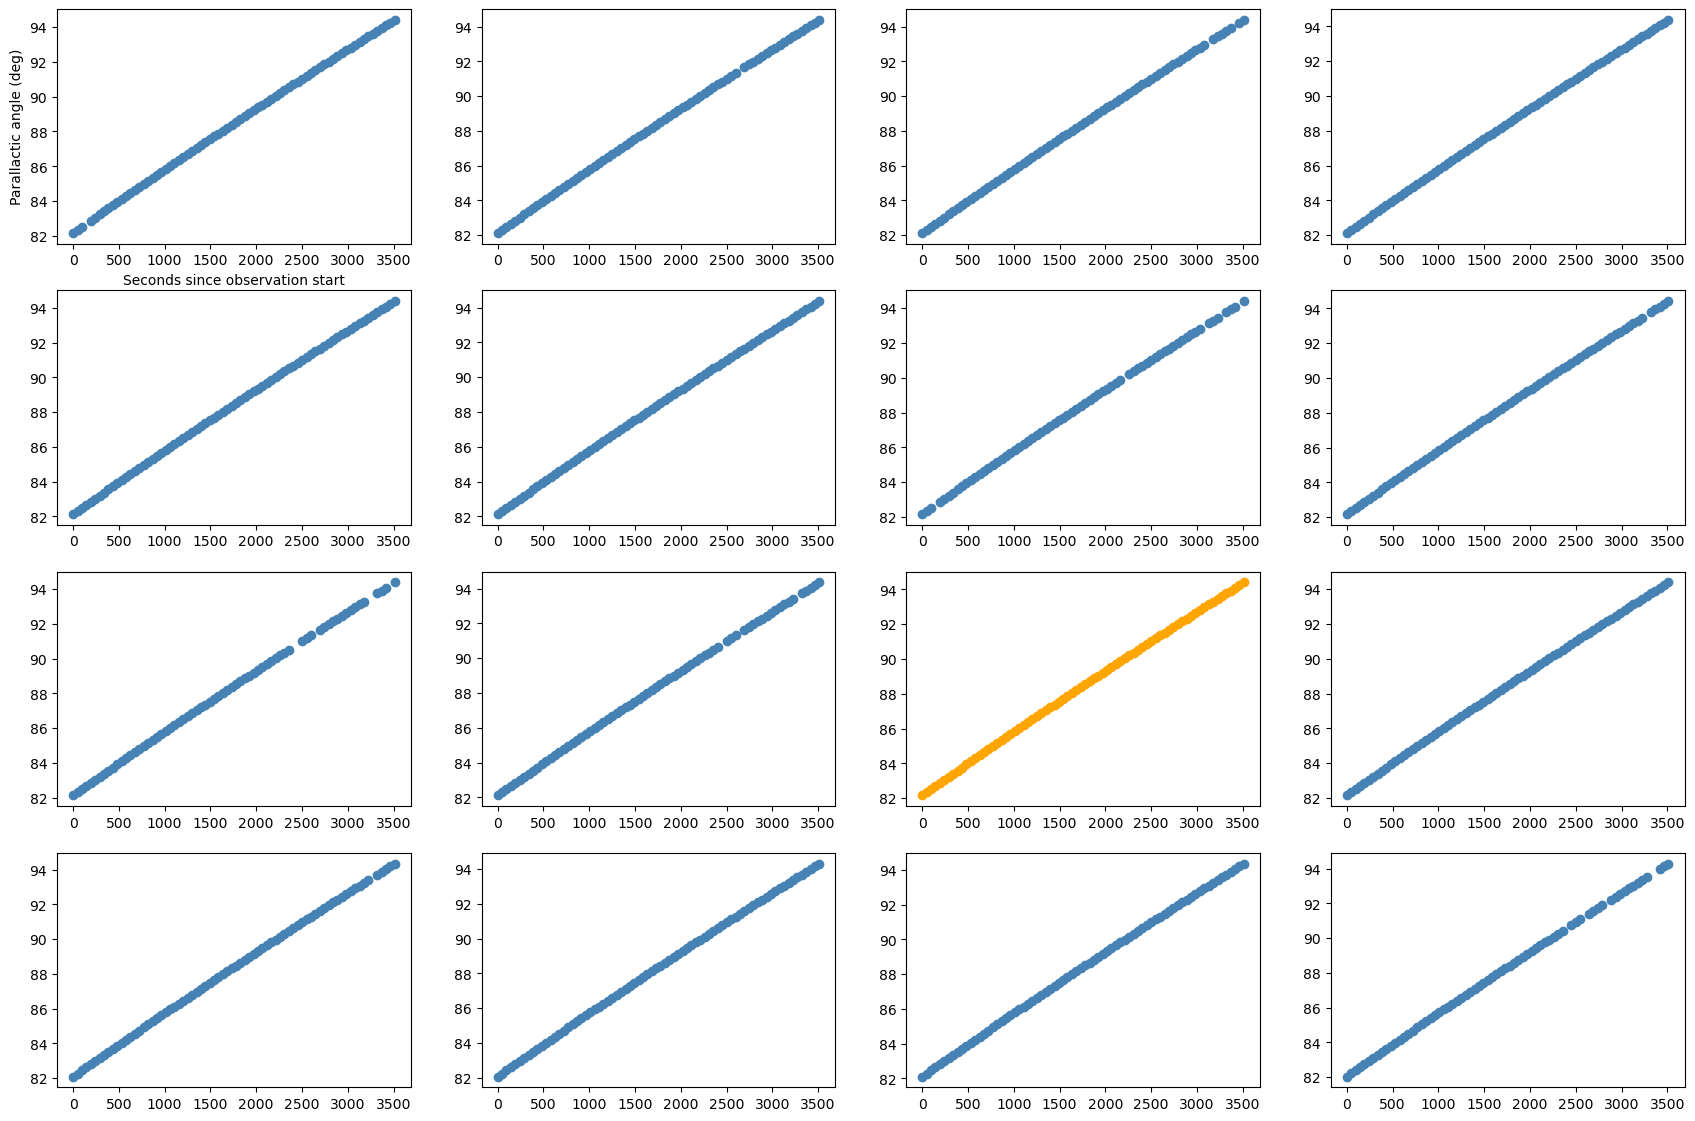

In [67]:
fig, ax = plt.subplots(4,4, figsize=(21,14))

for i in range(len(ax.flatten())):
    if i == FLAREINDX:
        color = 'orange'
    else:
        color = 'SteelBlue'
    ax.flatten()[i].errorbar(tSec, pa_arr[:,i], yerr = delpa_arr[:,i], color=color, marker='o', ls='None')

ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel('Parallactic angle (deg)');

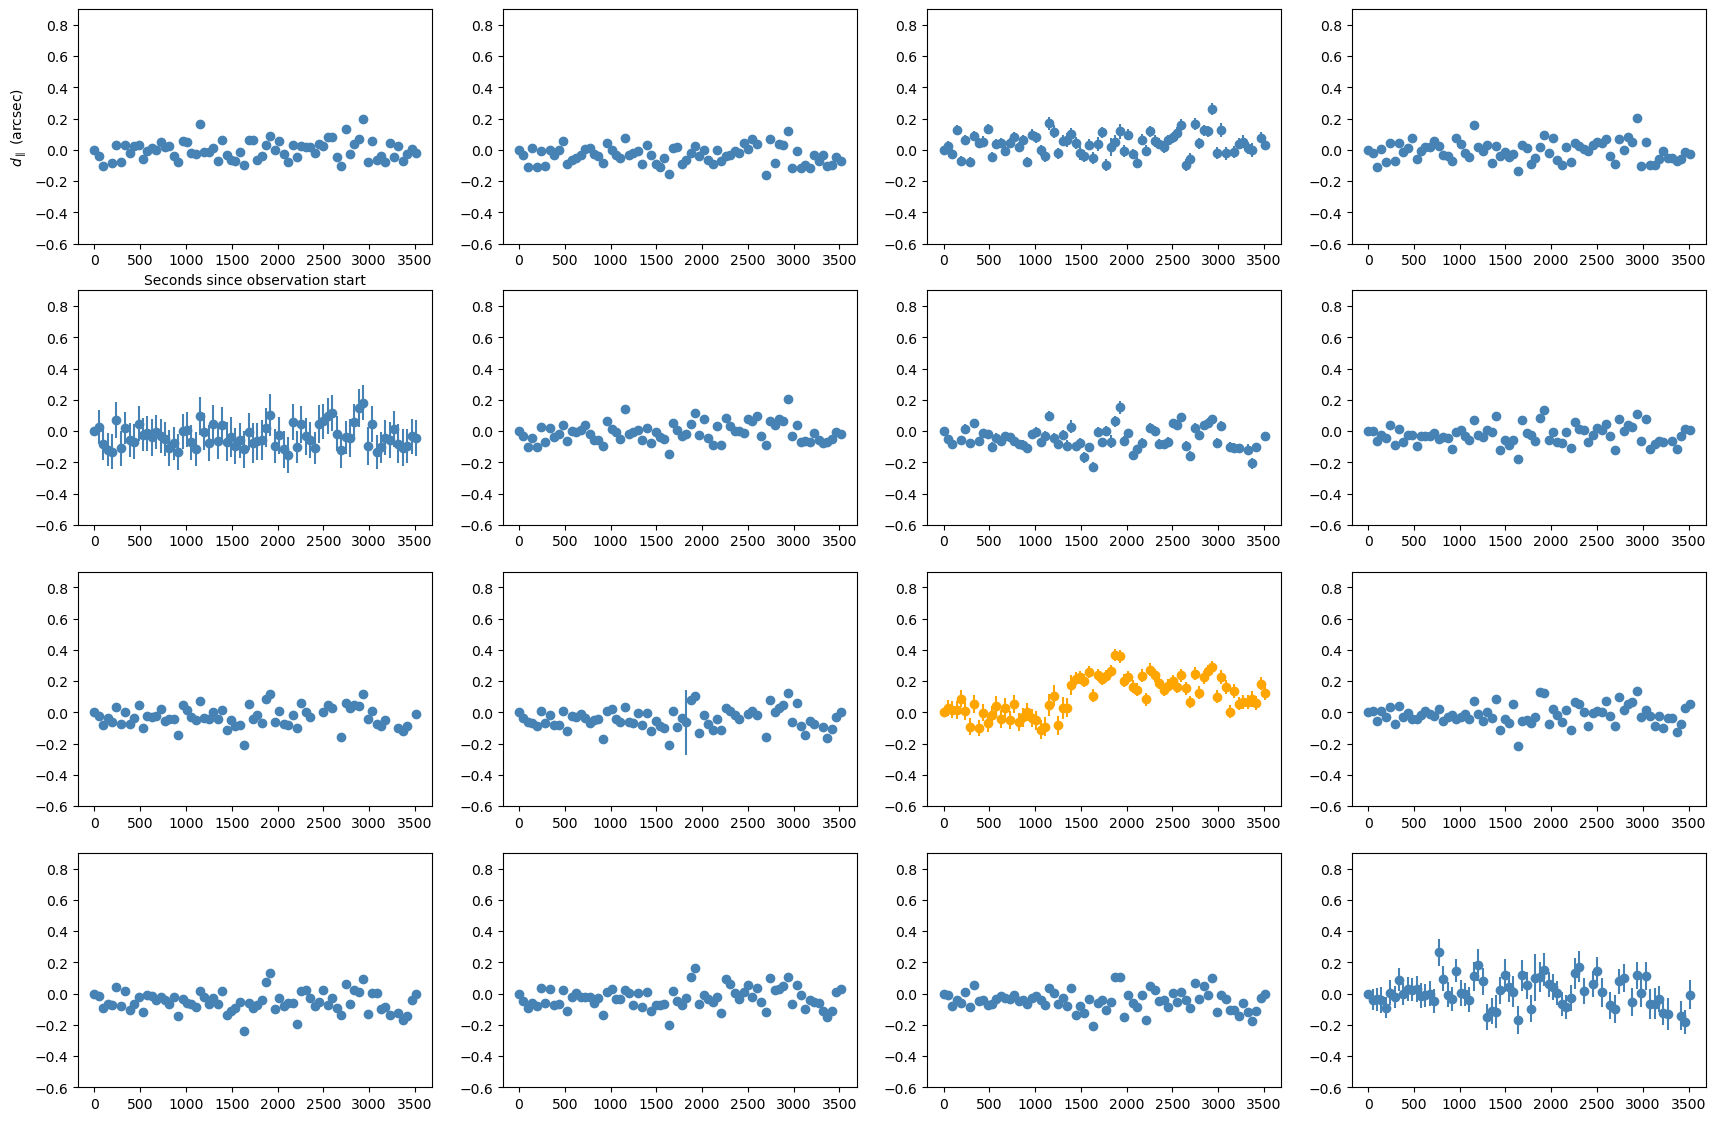

In [68]:
fig, ax = plt.subplots(4,4, figsize=(21,14))

for i in range(len(ax.flatten())):

    if i == flr_id-1:
        color = 'orange'
    else:
        color = 'SteelBlue'
   
    ax.flatten()[i].errorbar(tSec, dpar_arr[:,i] * D2ARCSEC, yerr = deldpar_arr[:,i] * D2ARCSEC, color=color, marker='o', ls='None')
    ax.flatten()[i].set_ylim(-0.6,0.9)

ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel(r'$d_{\parallel}$ (arcsec)');

### Converting $d_{\parallel}$ to $T_{eff}$

### Conditioning the $d_{\parallel}$ data

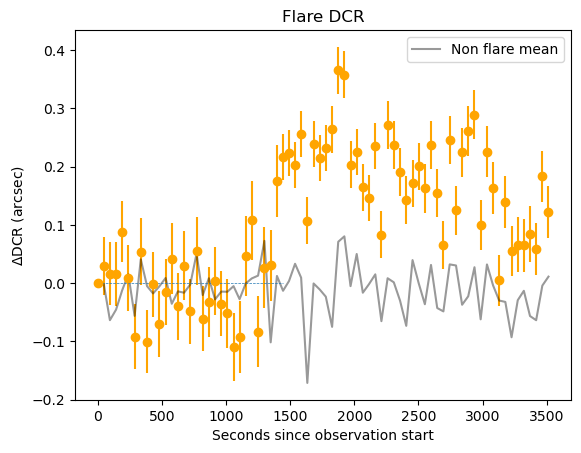

In [214]:
# FBB IMPORTANT! remove the flaring star from the average!!!
fig, ax = plt.subplots()
ax.errorbar(tSec, dpar_arr[:,flr_id-1] * D2ARCSEC, yerr = deldpar_arr[:,flr_id-1] * D2ARCSEC, 
            color='orange', marker='o', ls='None')
ax.plot(tSec, np.nanmean(dpar_arr_noflare, axis=1) * D2ARCSEC, c='k', alpha=0.4, label='Non flare mean')
plt.plot([tSec[0], tSec[30]], [0, 0], '--', lw=0.5)
ax.set_xlabel('Seconds since observation start')
ax.set_ylabel(r'$\Delta$DCR (arcsec)')
ax.set_title('Flare DCR')
ax.legend()

plt.savefig('Figures/raw_dpar.png', dpi = 300, bbox_inches='tight')

In [183]:
_ = np.ones((74,91))
for i in range(91):
    _[:,i] = i
_[:,fullstars].shape


(74, 34)

In [185]:
fullstars = (np.isnan(dpar_arr_noflare).sum(axis=0) == 0)
fullstars
print(f"number of stars detected in all frames {fullstars.sum()}")
dpar_arr_noflare_alldetected = dpar_arr_noflare[:,fullstars]

number of stars detected in all frames 34


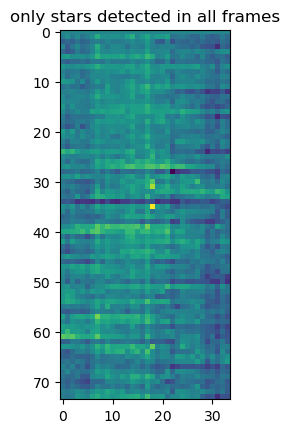

In [306]:
plt.imshow(dpar_arr_noflare_alldetected)
plt.title("only stars detected in all frames");

In [188]:
#create a masked array for the astrometry shift values
dpar_ma = np.ma.MaskedArray(dpar_arr_noflare, mask=np.isnan(dpar_arr_noflare))
dparerr_ma = dpar_ma.std(axis=1)
dparerr_ma = dparerr_ma.data.reshape((1,NDPS))
dparerr_ma.shape, dpar_ma.shape

((1, 74), (74, 91))

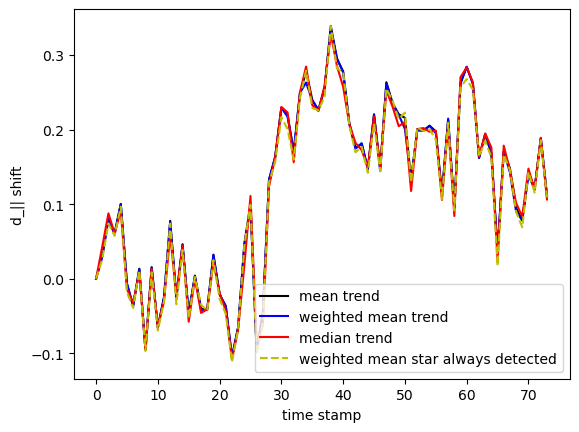

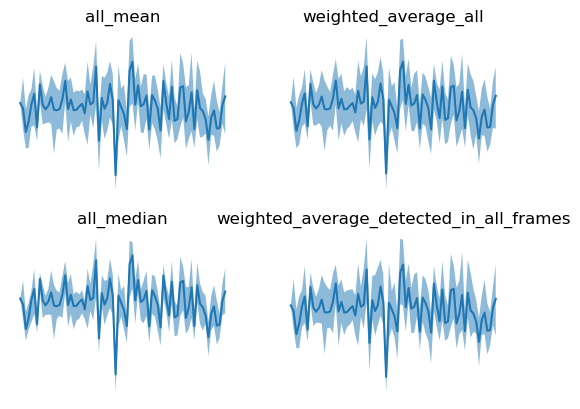

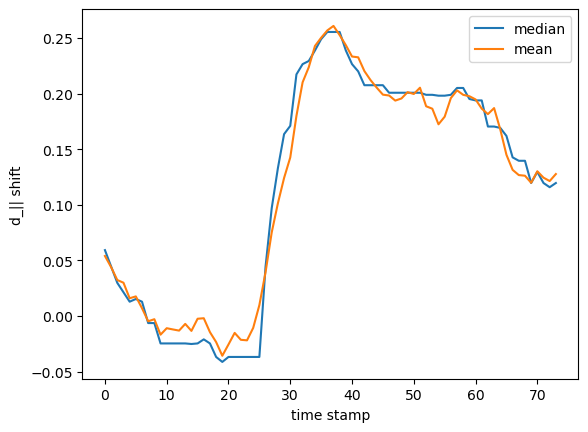

In [315]:
# start with the raw d_par for the flare star
dpar_raw = dpar_arr[:,flr_id-1] * D2ARCSEC 

####################define the trend as the mean of all star astrometric shifts 
dpar_trend = {}
dparerr_trend = {}

#plain mean of astrometric shifts
dpar_trend["all_mean"] = np.nanmean(dpar_arr_noflare, axis=1) * D2ARCSEC
dparerr_trend["all_mean"] = np.nanstd(dpar_arr_noflare_alldetected,axis=1) * D2ARCSEC #stdev

fig = plt.figure()
plt.plot(dpar_raw - dpar_trend["all_mean"], 'k', label="mean trend")

#weighted average of astrometric shifts
dpar_trend["weighted_average_all"] = np.average(dpar_ma, axis=1, weights=np.nanstd(dpar_arr_noflare, axis=0), ) * D2ARCSEC
dparerr_trend["weighted_average_all"] = dpar_ma.std(axis=1) * D2ARCSEC

plt.plot(dpar_raw - dpar_trend["weighted_average_all"], 'b', label="weighted mean trend")


#median of astrometric shifts
dpar_trend["all_median"] = np.nanmedian(dpar_arr_noflare, axis=1) * D2ARCSEC 
dparerr_trend["all_median_iqr_low"] = np.nanpercentile(dpar_arr_noflare, 25, axis=1) * D2ARCSEC
dparerr_trend["all_median_iqr_high"] = np.nanpercentile(dpar_arr_noflare, 75, axis=1) * D2ARCSEC

plt.plot(dpar_raw - dpar_trend["all_median"], 'r', label="median trend")


#weighted average of astrometric shifts only with stars detected in all frames
dpar_trend["weighted_average_detected_in_all_frames"] = np.average(dpar_arr_noflare_alldetected, axis=1, 
                          weights=dpar_arr_noflare_alldetected.std(axis=0)) * D2ARCSEC
dparerr_trend["weighted_average_detected_in_all_frames"] = dpar_arr_noflare_alldetected.std(axis=1) * D2ARCSEC

plt.plot(dpar_raw - dpar_trend["weighted_average_detected_in_all_frames"], 'y--',
                       label="weighted mean star always detected")

plt.legend()
plt.xlabel('time stamp')
plt.ylabel('d_|| shift')

fig, axs = plt.subplots(2,2)
axs = axs.ravel()
for i,k in enumerate(["all_mean", "weighted_average_all", "all_median", "weighted_average_detected_in_all_frames"]):
    if not k == "all_median":
        axs[i].fill_between(times, dpar_trend[k] - dparerr_trend[k], dpar_trend[k] + dparerr_trend[k], alpha=0.5)
        axs[i].plot(times, dpar_trend["all_median"])
    else:
        axs[i].fill_between(times, dparerr_trend[k+"_iqr_low"], dparerr_trend[k+"_iqr_high"], alpha=0.5)
        axs[i].plot(times, dpar_trend["all_median"])
    axs[i].set_title(k)
    axs[i].axis('off')


#################now remove trends

selecttrend = "weighted_average_all"
dpar_subtracted = dpar_raw - dpar_trend[selecttrend]

dparerr = deldpar_arr[:,FLAREINDX] * D2ARCSEC
dparerr[0] = np.nan #set the error in the first shift
dparerr_subtracted = np.sqrt(dparerr**2 + dparerr_trend[selecttrend]**2)

#################now smooth the time series

_ = pd.Series(dpar_subtracted).rolling(window, min_periods=1, center=True)
dpar_smoothed_mean = _.apply(np.nanmean)
dpar_smoothed_median = _.apply(np.nanmedian)

dpar_count = _.apply(lambda l: np.sum(~np.isnan(l)))

dparerr_smoothed_median = pd.Series(dparerr).rolling(window, min_periods=1, center=True).apply(lambda l: np.sqrt(np.nansum(l**2))) / dpar_count
dparerr_smoothed_mean = pd.Series(dparerr).rolling(window, min_periods=1, center=True).apply(lambda l: np.sqrt(np.nansum(l**2))) / dpar_count
#NB: they are the same...

plt.figure()
plt.plot(dpar_smoothed_median, label="median")
plt.plot(dpar_smoothed_mean, label="mean")
plt.xlabel("time stamp")
plt.ylabel('d_|| shift')
plt.legend()

flare_df = pd.DataFrame.from_dict({"mjd":times,
                                   "time": tSec,
                                    "dpar_smoothed":dpar_smoothed_median,
                                    "dparerr_smoothed":dparerr_smoothed_median,

                                    "dpar_raw": dpar_raw, #raw time series of dpar for flare star
                                    "dpar_error": dparerr,  #uncertainties in the raw time series of dpar for flare star

                                    "dpar_detrended": dpar_subtracted,  #trend removed - weighted average trend
                                    "dparerr_detrended": dparerr_subtracted,
                                    "dpar_detrended_mean" : dpar_raw - dpar_trend["all_mean"],
                                    "dparerr_detrended_mean" : dparerr - dparerr_trend["all_mean"],
                                    "dpar_detrended_median" : dpar_raw - dpar_trend["all_median"],
                                    "dparerr_detrended_iqr_low" : dparerr - dparerr_trend["all_median_iqr_low"],
                                    "dparerr_detrended_iqr_high" : dparerr - dparerr_trend["all_median_iqr_high"],
                                    "dpar_detrended_weightedav" : dpar_raw - dpar_trend["weighted_average_all"],
                                    "dparerr_detrended_weightedav" : dparerr - dparerr_trend["weighted_average_all"],
                                    "dpar_detrended_weightedav_detected_in_all_frames" : dpar_raw - dpar_trend["weighted_average_detected_in_all_frames"],
                                    "dparerr_detrended_weightedav_detected_in_all_frames" : dparerr - dparerr_trend["weighted_average_detected_in_all_frames"],
                                    "ensamble_dpar": dpar_trend[selecttrend],
                                    "ensamble_dparerr": dparerr_trend[selecttrend],

                                    "dpar_smoothed_median": dpar_smoothed_median,
                                    "dparerr_smoothed_median": dparerr_smoothed_median,
                                    "dpar_smoothed_mean": dpar_smoothed_mean,
                                    "dparerr_smoothed_mean": dparerr_smoothed_mean,
                                    "g_mag": delta_g_mag,
                                    "g_mag_error": delta_g_mag_err,
                                    "am" : flr_am,
                                   })
if SAVE: 
    flare_df.to_csv("Outdata/flare_df.csv")



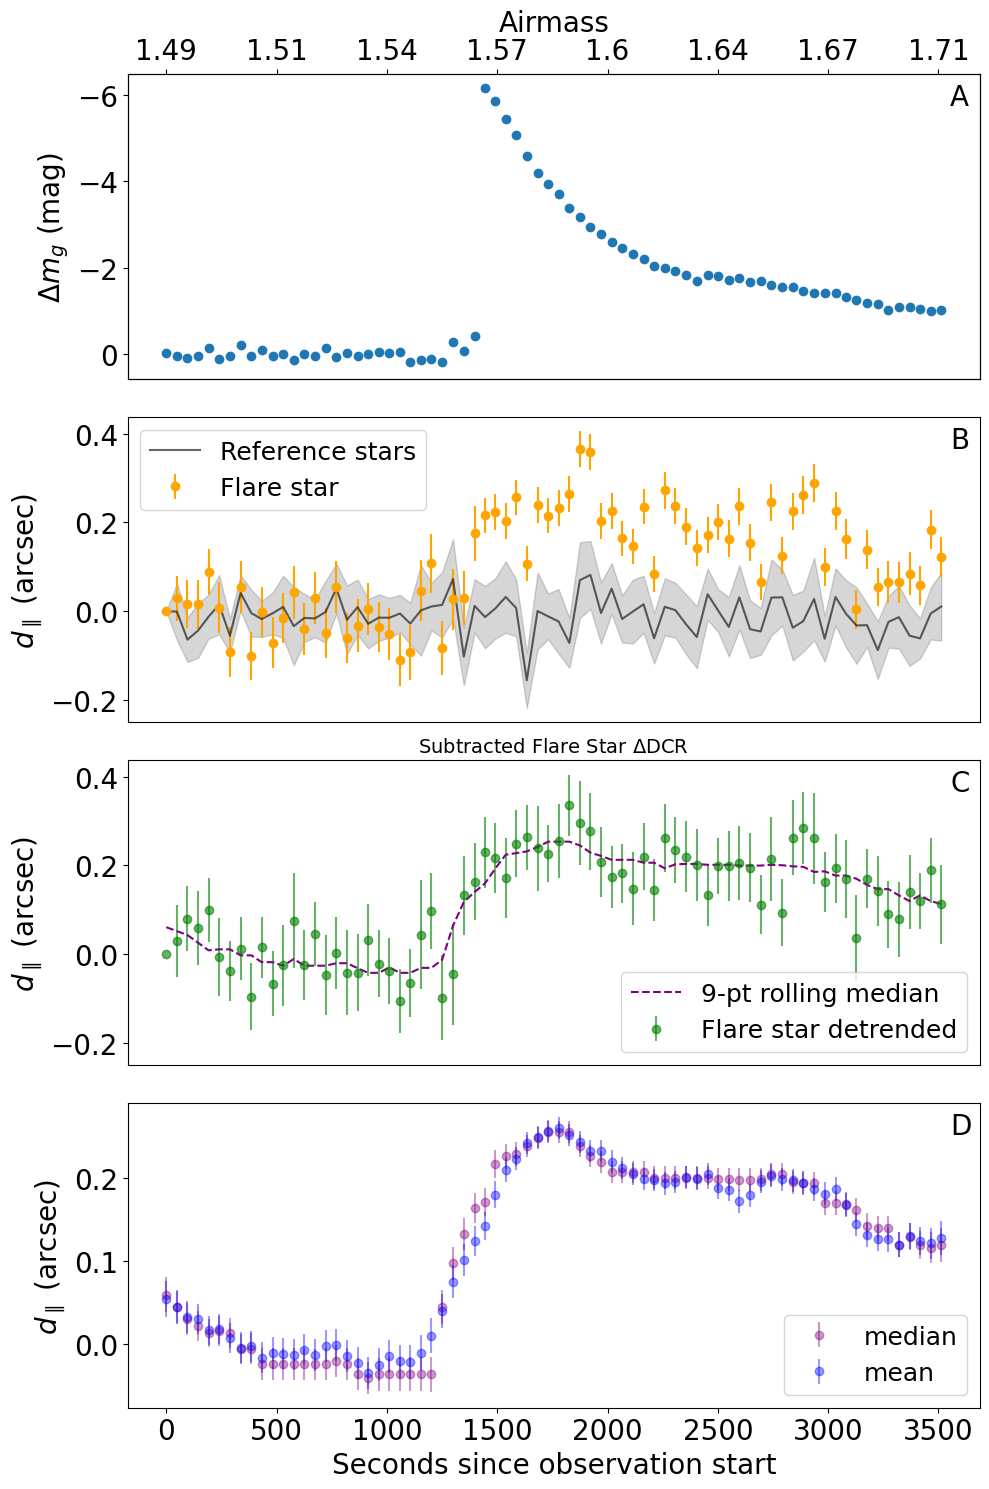

In [316]:

PLOT =True
if PLOT:
    fig, ax = plt.subplots(4,1, figsize=(10,15))

    ax[0].errorbar(flare_df.time, flare_df.g_mag, yerr = flare_df.g_mag_error, 
                   color='C0', marker='o', ls='None')
    ax[0].set_ylabel(r'$\Delta m_g$ (mag)', fontsize=14)
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[0].set_xticks([])

    ax[1].errorbar(flare_df.time, flare_df.dpar_raw, yerr = flare_df.dpar_error, 
                   color='orange', marker='o', ls='None', label='Flare star')
    ax[1].plot(flare_df.time, flare_df.ensamble_dpar, c='k', alpha = 0.6, label='Reference stars')
    ax[1].fill_between(flare_df.time, flare_df.ensamble_dpar-flare_df.ensamble_dparerr, 
                       flare_df.ensamble_dpar+flare_df.ensamble_dparerr, 
                       color='#333333', alpha = 0.2)
    #ax[0].set_xlabel('Seconds since observation start')
    ax[1].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[1].set_title(r'Flare Star $\Delta$DCR', fontsize=14)
    ax[1].legend(loc='upper left', fontsize=18)
    ax[1].set_xticks([])

    ax[2].errorbar(flare_df.time, flare_df.dpar_detrended, yerr = flare_df.dparerr_detrended, 
                color='green', marker='o', alpha=0.6, ls='None', label='Flare star detrended')
    ax[2].plot(flare_df.time, dpar_smoothed, 
               color='purple', ls='--', label='{}-pt rolling median'.format(window))

    
    ax[2].set_title(r'Subtracted Flare Star $\Delta$DCR', fontsize=14)
    ax[2].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    ax[2].set_ylim(ax[1].get_ylim())
    ax[2].legend(loc='lower right', fontsize=18)
    ax[2].set_xticks([])

    ax[3].errorbar(flare_df.time, flare_df.dpar_smoothed, yerr = flare_df.dparerr_smoothed, 
                   color='purple', alpha=0.4, ls='None', marker='o', label="median")
    ax[3].errorbar(flare_df.time, flare_df.dpar_smoothed_mean, yerr = flare_df.dparerr_smoothed, 
                   color='blue', alpha=0.4, ls='None', marker='o', label="mean")
    ax[3].set_xlabel('Seconds since observation start', fontsize=14)
    ax[3].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[3].set_title(r'Subtracted + Smoothed Flare Star $\Delta$DCR', fontsize=14)
    ax[3].legend(loc='lower right', fontsize=18)
    
    
    subax0 = ax[0].twiny()
    subax0.set_xticks(ax[3].get_xticks())
    subax0.set_xticklabels(np.round(flare_df.am[::8], decimals=2), fontsize=12)
    subax0.set_xlim(ax[0].get_xlim())
    subax0.set_xlabel('Airmass', fontsize=20)
    subax0.tick_params(labelsize=20)
    
    for axis, label in zip(ax, ['A', 'B', 'C', 'D']):
        axis.annotate(label, xy=(0.965,0.9), xycoords='axes fraction', fontsize=20)
        axis.tick_params(axis='both', labelsize=20)
        axis.set_xlabel(axis.get_xlabel(), fontsize=20)
        axis.set_ylabel(axis.get_ylabel(), fontsize=20)


    fig.tight_layout()

    plt.savefig('Figures/subtractedrolled_dpar_rough.png', dpi = 300, bbox_inches='tight')

np.save('Outdata/dpar_smoothed.npy', dpar_smoothed)
np.save('Outdata/dparerr_smoothed.npy', dparerr_smoothed)

In [313]:
def calculate_reduced_chi_squared(observed, expected_value, errors):
    """
    Calculate the reduced chi-squared statistic.

    Parameters:
    observed (array-like): The observed values (e.g., dpar_subtracted).
    expected_value (float): The single expected value to compare against.
    errors (array-like): The errors associated with the observed values.

    Returns:
    float: The reduced chi-squared statistic.
    """
    # Ensure the arrays are numpy arrays for consistency
    observed = np.array(observed)
    errors = np.array(errors)

    # Calculate the chi-squared statistic
    chi_squared = np.nansum((observed - expected_value) ** 2 / errors ** 2)

    # Calculate the degrees of freedom
    degrees_of_freedom = len(observed[~np.isnan(observed)]) - 1

    # Return the reduced chi-squared statistic
    return chi_squared / degrees_of_freedom

Reduced chi square = 6.320726793379021


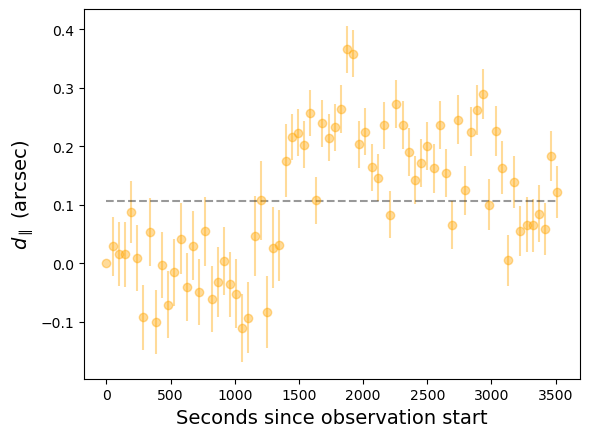

In [266]:
lineVal = np.nanmean(dpar_raw)#[tSec < 1000])

chi_squared = calculate_reduced_chi_squared(dpar_raw, lineVal, dparerr)

plt.errorbar(tSec, dpar_raw, yerr = dparerr, color='orange', alpha=0.4, ls='None', marker='o')
plt.plot(tSec, np.full_like(dpar_raw, lineVal), color='k', alpha=0.4, ls='--')
plt.xlabel('Seconds since observation start', fontsize=14)
plt.ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)

print("Reduced chi square = {}".format(chi_squared))

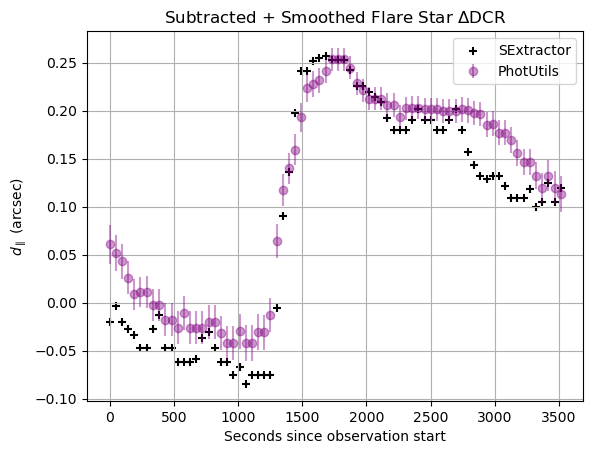

In [267]:
dparsex = np.load('Outdata/dpar_sextractor.npy')

plt.errorbar(tSec, dpar_smoothed, yerr = dparerr_smoothed, color='purple', alpha=0.4, ls='None', marker='o', label='PhotUtils')
plt.scatter(tSec, dparsex-0.1, color='k', ls='None', marker='+', label='SExtractor', zorder=0)

plt.xlabel('Seconds since observation start')
plt.ylabel(r'$d_\parallel$ (arcsec)')
plt.title(r'Subtracted + Smoothed Flare Star $\Delta$DCR')
plt.grid()
plt.legend()

In [269]:
##Saving data required for analysis to Outdata
#.npy
np.save('Outdata/dpar_arr.npy', dpar_arr)
np.save('Outdata/dpar_raw.npy', dpar_raw)
np.save('Outdata/dpar_subtracted.npy', dpar_subtracted.data)
np.save('Outdata/dparerr.npy', dparerr)
np.save('Outdata/delta_g_mag.npy', delta_g_mag)
np.save('Outdata/delta_g_mag_err.npy', delta_g_mag_err)
np.save('Outdata/times.npy', times)

#.csv
#np.savetxt('Outdata/delta_g_mag.csv', delta_g_mag)